### <font color='red'> Attention! This notebook takes a 16GB RAM laptop with an i7-8750H cpu and a Nvidia 1070 GPU 3.5 hours to run! </font> 
# Featured Prediction Competition of Home Credit Default Risk
#### Author: Xinyi Wei, Liangyawei Kuang
This notebook is used for a late submission in a Kaggle competition. The original competition website is [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  
The dataset should be put in a same file place with this notebook. You can download the dataset from [here](https://www.kaggle.com/competitions/home-credit-default-risk/data) or by using the Kaggle API `kaggle competitions download -c home-credit-default-risk`.  
This code was running on Jupyter notebook via Anaconda.  
## Requirements and Preliminaries
You should make sure your python version is correct.  
Python Verson: 3.9.7  
You also need to install four packages by running the code below before running all the other cells.  
`pip install lightgbm`  
`pip install xgboost`  
`pip install bayesian-optimization`  
`pip install hyperopt`
## Introduction
The goal of this competition is to predict whether an applicant has the ability to repay his/her loan by using historical loan data. It is a supervised classification mission.  
There are seven different data sources. And the relationship among them is shown as below.  
![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)
## Output_Metric: ROC AUC (or AUROC)
Our submission is judged by a common classification metric which is known as Receiver Operating Characteristic Area Under the Curve ROC AUC (or AUROC).  
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png width="250">  
By using this metric, we could easily identify a better model by judging whether its curve is to the left and above another curve. 

## Import packages

In [2]:
#pip install lightgbm
#pip install xgboost
#pip install bayesian-optimization
#pip install hyperopt
import pandas as pd 
import numpy as np 
import gc
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
import re
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization 
import lightgbm as lgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import pickle
from hyperopt import fmin,tpe,hp,partial 

## Data processing

In [3]:
#app_train：application_train.csv
#app_test：application_test.csv
#data_pre_application：previous_application.csv
#data_bureau：bureau.csv
#data_bur_balance：bureau_balance.csv
#data_POS_CASH：POS_CASH_balance.csv
#data_credit：credit_card_balance.csv
#data_ins_pay：installments_payments.csv

In [4]:
app_train = pd.read_csv('application_train.csv') 
app_test = pd.read_csv('application_test.csv') 

In [5]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data_pre_application=pd.read_csv('previous_application.csv') 
data_pre_application.describe().T 

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0,1.923089e+06,532597.958696,1.000001e+06,1.461857e+06,1.923110e+06,2.384280e+06,2845382.000
SK_ID_CURR,1670214.0,2.783572e+05,102814.823849,1.000010e+05,1.893290e+05,2.787145e+05,3.675140e+05,456255.000
AMT_ANNUITY,1297979.0,1.595512e+04,14782.137335,0.000000e+00,6.321780e+03,1.125000e+04,2.065842e+04,418058.145
AMT_APPLICATION,1670214.0,1.752339e+05,292779.762387,0.000000e+00,1.872000e+04,7.104600e+04,1.803600e+05,6905160.000
AMT_CREDIT,1670213.0,1.961140e+05,318574.616546,0.000000e+00,2.416050e+04,8.054100e+04,2.164185e+05,6905160.000
AMT_DOWN_PAYMENT,774370.0,6.697402e+03,20921.495410,-9.000000e-01,0.000000e+00,1.638000e+03,7.740000e+03,3060045.000
AMT_GOODS_PRICE,1284699.0,2.278473e+05,315396.557937,0.000000e+00,5.084100e+04,1.123200e+05,2.340000e+05,6905160.000
HOUR_APPR_PROCESS_START,1670214.0,1.248418e+01,3.334028,0.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,23.000
NFLAG_LAST_APPL_IN_DAY,1670214.0,9.964675e-01,0.059330,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000
RATE_DOWN_PAYMENT,774370.0,7.963682e-02,0.107823,-1.497876e-05,0.000000e+00,5.160508e-02,1.089091e-01,1.000


In [8]:
data_bureau=pd.read_csv('bureau.csv')
data_bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08


In [9]:
data_bur_balance=pd.read_csv('bureau_balance.csv')
data_bur_balance.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0,6.036297e+06,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0
MONTHS_BALANCE,27299925.0,-3.074169e+01,23.864509,-96.0,-46.0,-25.0,-11.0,0.0


In [10]:
data_POS_CASH=pd.read_csv('POS_CASH_balance.csv')
data_POS_CASH.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.0,1.903217e+06,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0
SK_ID_CURR,10001358.0,2.784039e+05,102763.745090,100001.0,189550.0,278654.0,367429.0,456255.0
MONTHS_BALANCE,10001358.0,-3.501259e+01,26.066570,-96.0,-54.0,-28.0,-13.0,-1.0
CNT_INSTALMENT,9975287.0,1.708965e+01,11.995056,1.0,10.0,12.0,24.0,92.0
CNT_INSTALMENT_FUTURE,9975271.0,1.048384e+01,11.109058,0.0,3.0,7.0,14.0,85.0
SK_DPD,10001358.0,1.160693e+01,132.714043,0.0,0.0,0.0,0.0,4231.0
SK_DPD_DEF,10001358.0,6.544684e-01,32.762491,0.0,0.0,0.0,0.0,3595.0


In [11]:
data_credit=pd.read_csv('credit_card_balance.csv')
data_credit.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,3840312.0,1.904504e+06,536469.470563,1000018.000,1434385.00,1897122.0,2.369328e+06,2843496.000
SK_ID_CURR,3840312.0,2.783242e+05,102704.475133,100006.000,189517.00,278396.0,3.675800e+05,456250.000
MONTHS_BALANCE,3840312.0,-3.452192e+01,26.667751,-96.000,-55.00,-28.0,-1.100000e+01,-1.000
AMT_BALANCE,3840312.0,5.830016e+04,106307.031025,-420250.185,0.00,0.0,8.904669e+04,1505902.185
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,1.538080e+05,165145.699523,0.000,45000.00,112500.0,1.800000e+05,1350000.000
AMT_DRAWINGS_ATM_CURRENT,3090496.0,5.961325e+03,28225.688579,-6827.310,0.00,0.0,0.000000e+00,2115000.000
AMT_DRAWINGS_CURRENT,3840312.0,7.433388e+03,33846.077334,-6211.620,0.00,0.0,0.000000e+00,2287098.315
AMT_DRAWINGS_OTHER_CURRENT,3090496.0,2.881696e+02,8201.989345,0.000,0.00,0.0,0.000000e+00,1529847.000
AMT_DRAWINGS_POS_CURRENT,3090496.0,2.968805e+03,20796.887047,0.000,0.00,0.0,0.000000e+00,2239274.160
AMT_INST_MIN_REGULARITY,3535076.0,3.540204e+03,5600.154122,0.000,0.00,0.0,6.633911e+03,202882.005


In [12]:
data_ins_pay=pd.read_csv('installments_payments.csv')
data_ins_pay.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.000,1896520.000,2369094.000,2843499.000
SK_ID_CURR,13605401.0,2.784449e+05,102718.310411,100001.0,189639.000,278685.000,367530.000,456255.000
NUM_INSTALMENT_VERSION,13605401.0,8.566373e-01,1.035216,0.0,0.000,1.000,1.000,178.000
NUM_INSTALMENT_NUMBER,13605401.0,1.887090e+01,26.664067,1.0,4.000,8.000,19.000,277.000
DAYS_INSTALMENT,13605401.0,-1.042270e+03,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000
DAYS_ENTRY_PAYMENT,13602496.0,-1.051114e+03,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000
AMT_INSTALMENT,13605401.0,1.705091e+04,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845
AMT_PAYMENT,13602496.0,1.723822e+04,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845


## Processing to Outlier

In [13]:
#Replace outliers with missing values\
#previous_application
pre_missing=['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']
for pre_mis in pre_missing:
    data_pre_application[pre_mis].replace(365243, np.nan, inplace= True) #365243 is an abnormal value
#bureau
data_bureau['DAYS_CREDIT_ENDDATE'][data_bureau['DAYS_CREDIT_ENDDATE']<-365*100]=np.nan #It is impossible that the customer had a loan 100 years ago
data_bureau['DAYS_ENDDATE_FACT'][data_bureau['DAYS_ENDDATE_FACT']<-365*100]=np.nan #It can't be more than 100 years
data_bureau['AMT_CREDIT_MAX_OVERDUE'][data_bureau['AMT_CREDIT_MAX_OVERDUE']>10000000]=np.nan #The data is too large and may be abnormal
data_bureau['AMT_CREDIT_SUM'][data_bureau['AMT_CREDIT_SUM']>10000000]=np.nan #The data is too large and may be abnormal
data_bureau['AMT_CREDIT_SUM_DEBT'][data_bureau['AMT_CREDIT_SUM_DEBT']>50000000]=np.nan #It's unlikely that there will be so many loans
data_bureau['AMT_CREDIT_SUM_DEBT'][data_bureau['AMT_CREDIT_SUM_DEBT']<0]=np.nan #Negative values make no sense
data_bureau['AMT_ANNUITY'][data_bureau['AMT_ANNUITY']>=10000000]=np.nan #The data is too large and may be abnormal
data_credit['AMT_DRAWINGS_ATM_CURRENT'][data_credit['AMT_DRAWINGS_ATM_CURRENT']<0]=np.nan #Negative values make no sense
data_credit['AMT_DRAWINGS_CURRENT'][data_credit['AMT_DRAWINGS_CURRENT']<0]=np.nan #Negative values make no sense
#application
app_train['AMT_INCOME_TOTAL'][app_train['AMT_INCOME_TOTAL']>100000000]=np.nan #One person has an income of more than 100000000
app_test['AMT_INCOME_TOTAL'][app_test['AMT_INCOME_TOTAL']>100000000]=np.nan
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
app_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
app_test['REGION_RATING_CLIENT_W_CITY'].replace(-1, np.nan, inplace= True) #Test has an abnormal value of - 1，Train data is normal
app_train['OBS_30_CNT_SOCIAL_CIRCLE'][app_train['OBS_30_CNT_SOCIAL_CIRCLE']>100]=np.nan #354 may be an outlier，More than 300 people observed that there was little possibility of defaulting on loans
app_test['OBS_30_CNT_SOCIAL_CIRCLE'][app_test['OBS_30_CNT_SOCIAL_CIRCLE']>100]=np.nan
app_train['OBS_60_CNT_SOCIAL_CIRCLE'][app_train['OBS_60_CNT_SOCIAL_CIRCLE']>100]=np.nan #Ibid., it is unlikely that more than 100 people find it
app_test['OBS_60_CNT_SOCIAL_CIRCLE'][app_test['OBS_60_CNT_SOCIAL_CIRCLE']>100]=np.nan
app_train['AMT_REQ_CREDIT_BUREAU_QRT'][app_train['AMT_REQ_CREDIT_BUREAU_QRT']>100]=np.nan #261 may be an abnormal value. It is unlikely that the number of inquiries to the credit bureau is so many
app_test['AMT_REQ_CREDIT_BUREAU_QRT'][app_test['AMT_REQ_CREDIT_BUREAU_QRT']>100]=np.nan

In [14]:
#The value of some variables cannot be less than 0, set the minimum value of these variables to 0
#previous_application
pre_max0=['SELLERPLACE_AREA','AMT_DOWN_PAYMENT']
for max0 in pre_max0: 
    data_pre_application[max0] = np.maximum(data_pre_application[max0], 0) #There are several outliers less than 0. But from their meaning, it can't be less than 0

In [15]:
#Some variables are negative, but their financial meaning should be positive. Take their absolute value
#previous_application
data_pre_application["DAYS_DECISION"]=abs(data_pre_application["DAYS_DECISION"]) #Distance days should be positive
#bureau
data_bureau['DAYS_CREDIT']=abs(data_bureau['DAYS_CREDIT'])  #Distance days should be positive
#bureau_balance
data_bur_balance['MONTHS_BALANCE']=abs(data_bur_balance['MONTHS_BALANCE']) #The distance month should be positive
#POS_CASH_balance
data_POS_CASH['MONTHS_BALANCE']=abs(data_POS_CASH['MONTHS_BALANCE']) #The distance month should be positive
#credit_card_balance
data_credit['MONTHS_BALANCE']=abs(data_credit['MONTHS_BALANCE'])#The distance month should be positive
#installments_payments
data_ins_pay['DAYS_INSTALMENT']=abs(data_ins_pay['DAYS_INSTALMENT'])
data_ins_pay['DAYS_ENTRY_PAYMENT']=abs(data_ins_pay['DAYS_ENTRY_PAYMENT'])
#application
app_train['DAYS_BIRTH']=abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH']=abs(app_test['DAYS_BIRTH'])
app_train['DAYS_REGISTRATION']=abs(app_train['DAYS_REGISTRATION'])
app_test['DAYS_REGISTRATION']=abs(app_test['DAYS_REGISTRATION'])
app_train['DAYS_ID_PUBLISH']=abs(app_train['DAYS_ID_PUBLISH'])
app_test['DAYS_ID_PUBLISH']=abs(app_test['DAYS_ID_PUBLISH'])
app_train['DAYS_LAST_PHONE_CHANGE']=abs(app_train['DAYS_LAST_PHONE_CHANGE'])
app_test['DAYS_LAST_PHONE_CHANGE']=abs(app_test['DAYS_LAST_PHONE_CHANGE'])

In [16]:
data_pre_application.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0,1.923089e+06,532597.958696,1.000001e+06,1.461857e+06,1.923110e+06,2.384280e+06,2845382.000
SK_ID_CURR,1670214.0,2.783572e+05,102814.823849,1.000010e+05,1.893290e+05,2.787145e+05,3.675140e+05,456255.000
AMT_ANNUITY,1297979.0,1.595512e+04,14782.137335,0.000000e+00,6.321780e+03,1.125000e+04,2.065842e+04,418058.145
AMT_APPLICATION,1670214.0,1.752339e+05,292779.762387,0.000000e+00,1.872000e+04,7.104600e+04,1.803600e+05,6905160.000
AMT_CREDIT,1670213.0,1.961140e+05,318574.616546,0.000000e+00,2.416050e+04,8.054100e+04,2.164185e+05,6905160.000
AMT_DOWN_PAYMENT,774370.0,6.697402e+03,20921.495409,0.000000e+00,0.000000e+00,1.638000e+03,7.740000e+03,3060045.000
AMT_GOODS_PRICE,1284699.0,2.278473e+05,315396.557937,0.000000e+00,5.084100e+04,1.123200e+05,2.340000e+05,6905160.000
HOUR_APPR_PROCESS_START,1670214.0,1.248418e+01,3.334028,0.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,23.000
NFLAG_LAST_APPL_IN_DAY,1670214.0,9.964675e-01,0.059330,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000
RATE_DOWN_PAYMENT,774370.0,7.963682e-02,0.107823,-1.497876e-05,0.000000e+00,5.160508e-02,1.089091e-01,1.000


## Character feature discretization

In [17]:
app_train = app_train.append(app_test).reset_index()
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

In [18]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [19]:
#app_train：application_train.csv
#app_test：application_test.csv
#data_pre_application：previous_application.csv
#data_bureau：bureau.csv
#data_bur_balance：bureau_balance.csv
#data_POS_CASH：POS_CASH_balance.csv
#data_credit：credit_card_balance.csv
#data_ins_pay：installments_payments.csv
data_pre_application, new_columns_pre_application = one_hot_encoder(data_pre_application)
data_bureau, new_columns_bureau=one_hot_encoder(data_bureau)
data_bur_balance, new_columns_bur_balance=one_hot_encoder(data_bur_balance)
data_POS_CASH, new_columns_POS_CASH=one_hot_encoder(data_POS_CASH)
data_credit, new_columns_credit=one_hot_encoder(data_credit)
data_ins_pay, new_columns_ins_pay=one_hot_encoder(data_ins_pay)
for train_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    app_train[train_feature], uniques = pd.factorize(app_train[train_feature])
app_train, new_columns_app_train=one_hot_encoder(app_train) 

## Derive scale class features

In [20]:
#previous_application
data_pre_application['APP_CREDIT_PERC'] = data_pre_application['AMT_APPLICATION'] / (data_pre_application['AMT_CREDIT']+ 0.00001)
data_pre_application['APPLICATION_CREDIT_DIFF'] = data_pre_application['AMT_APPLICATION'] - data_pre_application['AMT_CREDIT']
data_pre_application['APPLICATION_CREDIT_RATIO'] = data_pre_application['AMT_APPLICATION'] / (data_pre_application['AMT_CREDIT']+ 0.00001)
data_pre_application['CREDIT_TO_ANNUITY_RATIO'] = data_pre_application['AMT_CREDIT']/(data_pre_application['AMT_ANNUITY']+ 0.00001)
data_pre_application['DOWN_PAYMENT_TO_CREDIT'] = data_pre_application['AMT_DOWN_PAYMENT'] / (data_pre_application['AMT_CREDIT']+ 0.00001)
total_payment = data_pre_application['AMT_ANNUITY'] * data_pre_application['CNT_PAYMENT']
data_pre_application['SIMPLE_INTERESTS'] = (total_payment/data_pre_application['AMT_CREDIT'] - 1)/(data_pre_application['CNT_PAYMENT']+ 0.00001)
#application_train
app_train['DAYS_EMPLOYED_PERC'] = app_train['DAYS_EMPLOYED'] / (app_train['DAYS_BIRTH']+ 0.00001)
app_train['INCOME_CREDIT_PERC'] = app_train['AMT_INCOME_TOTAL'] / (app_train['AMT_CREDIT']+ 0.00001)
app_train['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / (app_train['CNT_FAM_MEMBERS']+ 0.00001)
app_train['ANNUITY_INCOME_PERC'] = app_train['AMT_ANNUITY'] / (app_train['AMT_INCOME_TOTAL']+ 0.00001)
app_train['PAYMENT_RATE'] = app_train['AMT_ANNUITY'] / (app_train['AMT_CREDIT']+ 0.00001)
app_train['EMPLOYED_TO_AGE_RATIO'] = app_train['DAYS_EMPLOYED'] / (app_train['DAYS_BIRTH']+ 0.00001)
app_train['CAR_EMPLOYED_RATIO'] = app_train['OWN_CAR_AGE'] / (app_train['DAYS_EMPLOYED']+ 0.00001)
app_train['CAR_AGE_RATIO'] = app_train['OWN_CAR_AGE'] / (app_train['DAYS_BIRTH']+ 0.00001)
app_train['CHILDREN_INCOME_RATIO'] = app_train['CNT_CHILDREN'] / (app_train['AMT_INCOME_TOTAL']+ 0.00001)
#installments_payments
data_ins_pay['PAYMENT_PERC'] = data_ins_pay['AMT_PAYMENT'] / (data_ins_pay['AMT_INSTALMENT']+ 0.00001)
data_ins_pay['PAYMENT_DIFF'] = data_ins_pay['AMT_INSTALMENT'] - data_ins_pay['AMT_PAYMENT']
data_ins_pay['DPD'] = data_ins_pay['DAYS_ENTRY_PAYMENT'] - data_ins_pay['DAYS_INSTALMENT']
data_ins_pay['DBD'] = data_ins_pay['DAYS_INSTALMENT'] - data_ins_pay['DAYS_ENTRY_PAYMENT']
#bureau
data_bureau['CREDIT_DURATION'] = np.abs(data_bureau['DAYS_CREDIT'] - data_bureau['DAYS_CREDIT_ENDDATE'])
data_bureau['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in data_bureau['CREDIT_DAY_OVERDUE']]
data_bureau['MAX_AMT_OVERDUE_DURATION_RATIO'] = data_bureau['AMT_CREDIT_MAX_OVERDUE'] / (data_bureau['CREDIT_DURATION']+ 0.00001)
data_bureau['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = data_bureau['AMT_CREDIT_SUM_OVERDUE'] / (data_bureau['CREDIT_DURATION']+ 0.00001)
data_bureau['AMT_OVERDUE_DURATION_LEFT_RATIO'] = data_bureau['AMT_CREDIT_SUM_OVERDUE'] / (data_bureau['DAYS_CREDIT_ENDDATE']+ 0.00001)
data_bureau['CNT_PROLONGED_MAX_OVERDUE_MUL'] = data_bureau['CNT_CREDIT_PROLONG'] * data_bureau['AMT_CREDIT_MAX_OVERDUE']
data_bureau['CNT_PROLONGED_DURATION_RATIO'] = data_bureau['CNT_CREDIT_PROLONG'] / (data_bureau['CREDIT_DURATION']+ 0.00001)
data_bureau['CURRENT_DEBT_TO_CREDIT_RATIO'] = data_bureau['AMT_CREDIT_SUM_DEBT'] / (data_bureau['AMT_CREDIT_SUM']+ 0.00001)
data_bureau['CURRENT_CREDIT_DEBT_DIFF'] = data_bureau['AMT_CREDIT_SUM'] - data_bureau['AMT_CREDIT_SUM_DEBT']
data_bureau['AMT_ANNUITY_CREDIT_RATIO'] = data_bureau['AMT_ANNUITY'] / (data_bureau['AMT_CREDIT_SUM']+ 0.00001)
data_bureau['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(data_bureau['DAYS_CREDIT_UPDATE'] - data_bureau['DAYS_CREDIT_ENDDATE'])

## Derive aggregate class features

In [21]:
num_aggregations = {'AMT_ANNUITY': ['min', 'max', 'mean'],
                    'AMT_APPLICATION': ['min', 'max', 'mean'], 
                    'AMT_CREDIT': ['min', 'max', 'mean'],
                    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'], 
                    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'], 
                    'AMT_GOODS_PRICE': ['min', 'max', 'mean'], 
                    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'], 
                    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'], 
                    'DAYS_DECISION': ['min', 'max', 'mean'], 
                    'CNT_PAYMENT': ['mean', 'sum'], 
                   } 
bur_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
bureau_aggregations = {'DAYS_CREDIT': ['min', 'max', 'mean', 'last'],
                       'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                       'DAYS_CREDIT_ENDDATE': ['max', 'mean'],
                       'DAYS_CREDIT_UPDATE': ['min', 'mean'],
                       'AMT_CREDIT_MAX_OVERDUE': ['max','mean'],
                       'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                       'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
                       'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                       'AMT_CREDIT_SUM_LIMIT': ['max', 'sum'],
                       'AMT_ANNUITY': ['max', 'mean','sum'],
                       'CNT_CREDIT_PROLONG': ['sum'],
                       'MONTHS_BALANCE_MIN': ['min'],
                       'MONTHS_BALANCE_MAX': ['max'],
                       'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
                       'CREDIT_DURATION' : ['max','mean'],
                       'FLAG_OVERDUE_RECENT': ['sum'],
                       'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                       'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                       'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                       'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                       'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                       'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                       'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                       'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                      }
pos_aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'],
                    'SK_DPD': ['max', 'mean'],
                    'SK_DPD_DEF': ['max', 'mean']
                   }
ins_aggregations = {'NUM_INSTALMENT_VERSION': ['nunique'],
                    'DPD': ['max', 'mean', 'sum'],
                    'DBD': ['max', 'mean', 'sum'],
                    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
                    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
                    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
                    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
                    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
                   }
bur_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}      


In [22]:
#bb=data_bur_balance
#bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in new_columns_bur_balance:
    bur_balance_aggregations[col] = ['mean']
bb_agg = data_bur_balance.groupby('SK_ID_BUREAU').agg(bur_balance_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
data_bureau = data_bureau.join(bb_agg, how='left', on='SK_ID_CURR')
data_bur_balance.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

# for col in new_columns_bur_balance:
#     bur_balance_aggregations[col] = ['mean']
# bur_balance_agg = data_bur_balance.groupby('SK_ID_BUREAU').agg(bur_balance_aggregations)
# bur_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bur_balance_agg.tolist()])
#ata_bureau = data_bureau.join(bur_balance_agg, how='left', on='SK_ID_BUREAU')


# data_bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
data_credit.drop(['SK_ID_PREV'], axis= 1, inplace = True)

## Categorical features

In [23]:
cat_aggregations = {} 
for cat in new_columns_pre_application: 
    cat_aggregations[cat] = ['mean']

bur_aggregations = {} 
for bur in new_columns_bureau: 
    bur_aggregations[bur] = ['mean']
for bur in new_columns_bur_balance: 
    bur_aggregations[bur + "_MEAN"] = ['mean']
    
for posh in new_columns_POS_CASH:
    pos_aggregations[posh] = ['mean']

for ins in new_columns_ins_pay:
    ins_aggregations[ins] = ['mean']

In [24]:
prev_agg = data_pre_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_'+column[0]+'_'+column[1].upper() for column in prev_agg.columns.tolist()])
bureau_agg = data_bureau.groupby('SK_ID_CURR').agg({**bureau_aggregations, **bur_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
pos_agg = data_POS_CASH.groupby('SK_ID_CURR').agg(pos_aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
ins_agg = data_ins_pay.groupby('SK_ID_CURR').agg(ins_aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
cc_agg = data_credit.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

## Historical Application Pass & Rejection Features

In [25]:
#historical pass features
approved = data_pre_application[data_pre_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_'+column[0]+'_'+column[1]. upper() for column in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
#historical rejection features
refused = data_pre_application[data_pre_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_'+column[0]+'_'+column[1].upper() for column in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

## Active & Closed Features

In [26]:
#active features
active = data_bureau[data_bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(bureau_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
#closed credits
closed = data_bureau[data_bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(bureau_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

## Size Features

In [27]:
pos_agg['POS_COUNT'] = data_POS_CASH.groupby('SK_ID_CURR').size()
ins_agg['INSTAL_COUNT'] = data_ins_pay.groupby('SK_ID_CURR').size()
cc_agg['CC_COUNT'] = data_credit.groupby('SK_ID_CURR').size()

## Construct feature from EXT_SOURCE

In [28]:
app_train['EXT_SOURCE_MEAN'] = (app_train['EXT_SOURCE_1'] + app_train['EXT_SOURCE_2'] + app_train['EXT_SOURCE_3'] ) / 3
app_train['EXT_SOURCE_MUL'] = app_train['EXT_SOURCE_1'] * app_train['EXT_SOURCE_2'] * app_train['EXT_SOURCE_3']
app_train['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(app_train['EXT_SOURCE_1'], app_train['EXT_SOURCE_2'], app_train['EXT_SOURCE_3'])]
app_train['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(app_train['EXT_SOURCE_1'], app_train['EXT_SOURCE_2'], app_train['EXT_SOURCE_3'])]
app_train['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(app_train['EXT_SOURCE_1'], app_train['EXT_SOURCE_2'], app_train['EXT_SOURCE_3'])]
app_train['WEIGHTED_EXT_SOURCE'] =  app_train.EXT_SOURCE_1 * 2 + app_train.EXT_SOURCE_2 * 3 + app_train.EXT_SOURCE_3 * 4

##  Merge

In [29]:
app_train = app_train.join(bureau_agg, how='left', on='SK_ID_CURR')
app_train = app_train.join(prev_agg, how='left', on='SK_ID_CURR')
app_train = app_train.join(pos_agg, how='left', on='SK_ID_CURR')
app_train = app_train.join(ins_agg, how='left', on='SK_ID_CURR')
app_train = app_train.join(cc_agg, how='left', on='SK_ID_CURR')

In [30]:
app_train

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
app_train.to_csv('app_train3.csv', index = False)

In [32]:
app_train = pd.read_csv('app_train3.csv') 

## EDA analysis-filter feature

In [33]:
def EDA_series(data):
    result = {}
    result['count'] = len(data)
    result['missing_count'] = data.isnull().sum() 
    result['missing_rate'] = result['missing_count'] / result['count'] 
    result['count_unique'] = len(data.value_counts(normalize=True)) 
    data.dropna(inplace=True) 
    if data.dtype=='object': 
        result['type'] = 'categorical' 
    else: 
        result['type'] = 'numeric' 
        result['max'] = data.max() 
        result['min'] = data.min() 
        result['mean'] = data.mean() 
        result['std'] = data.std() 
        zscore = (data-data.mean()) / data.std() 
        result['outlier_count'] = (zscore.abs()>6).sum() 
        result['outlier_rate'] = result['outlier_count'] / result['count'] 
    if result['count_unique']<=2: 
        result['type'] = 'binary' 
    result = pd.Series(result) 
    return result

In [34]:
def EDA_df(data):
    result = []
    for column in data.columns.tolist(): 
        tmp = EDA_series(data[column])
        tmp.name = column 
        result.append(tmp) 
    result = pd.concat(result,axis=1).T 
    columns_result = ['type','count','count_unique','max','min','mean','std','missing_count','missing_rate','outlier_count','outlier_rate'] 
    result = result[columns_result] 
    return result

In [35]:
train_test=EDA_df(app_train)
train_test

,type,count,count_unique,max,min,mean,std,missing_count,missing_rate,outlier_count,outlier_rate
index,numeric,356251,307509,307510,0,136052.869904,93841.582375,0,0.0,0,0.0
SK_ID_CURR,numeric,356251,356251,456255,100001,278128.870078,102842.06889,0,0.0,0,0.0
TARGET,binary,356251,2,1.0,0.0,0.08073,0.27242,48744,0.136825,0,0.0
CODE_GENDER,binary,356251,2,1,0,0.660001,0.473709,0,0.0,0,0.0
FLAG_OWN_CAR,binary,356251,2,1,0,0.339699,0.473608,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
CC_NAME_CONTRACT_STATUS_nan_MAX,binary,356251,1,0.0,0.0,0.0,0.0,252693,0.709312,0,0.0
CC_NAME_CONTRACT_STATUS_nan_MEAN,binary,356251,1,0.0,0.0,0.0,0.0,252693,0.709312,0,0.0
CC_NAME_CONTRACT_STATUS_nan_SUM,binary,356251,1,0.0,0.0,0.0,0.0,252693,0.709312,0,0.0
CC_NAME_CONTRACT_STATUS_nan_VAR,binary,356251,1,0.0,0.0,0.0,0.0,253385,0.711254,0,0.0


In [36]:
train_test=train_test.iloc[3:,:]

In [37]:
delet_factor=[]
for inx in train_test.index.tolist(): 
    if train_test.loc[inx]['missing_rate']>0.9:
        delet_factor.append(inx)
    if train_test.loc[inx]['count_unique']<=1:
        delet_factor.append(inx)

In [38]:
delet_factor=np.unique(delet_factor)

In [39]:
delet_factor

array(['ACTIVE_MONTHS_BALANCE_MAX_MAX', 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
       'ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
       'ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'BURO_CREDIT_ACTIVE_nan_MEAN',
       'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
       'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_MONTHS_BALANCE_MIN_MIN',
       'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_MONTHS_BALANCE_SIZE_SUM',
       'BURO_STATUS_0_MEAN_MEAN', 'BURO_STATUS_1_MEAN_MEAN',
       'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN',
       'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
       'BURO_STATUS_C_MEAN_MEAN', 'BURO_STATUS_X_MEAN_MEAN',
       'BURO_STATUS_nan_MEAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_Approved_MIN',
       'CC_NAME_CONTRACT_STATUS_Refused_MIN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX',
       'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM',
       'C

In [40]:
app_train.drop(delet_factor, axis=1, inplace=True)
app_train

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
app_train.to_csv('app_train4.csv', index = False)

## Standardizing the data

In [42]:
train_data = app_train[app_train['TARGET'].notnull()]
test_data = app_train[app_train['TARGET'].isnull()]
#removing the SK_ID_CURR from training and test data
train_data = train_data.drop(['SK_ID_CURR'], axis = 1)
skid_test = test_data.pop('SK_ID_CURR')
#extracting the class labels for training data
target_train = train_data.pop('TARGET')
test_data = test_data.drop(['TARGET'], axis = 1)
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

In [43]:
#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0
x_train=x_train_std

## Method1: Logistic Regression

In [44]:
params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

base_model=clf
num_folds=4
kfolds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 98)
rscv = RandomizedSearchCV(clf, hyperparams, n_iter = 15, scoring = 'roc_auc',return_train_score = True, verbose = 2,n_jobs = 2)
rscv.fit(x_train, y_train)
tuning_results = pd.DataFrame(rscv.cv_results_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [45]:
best_model = rscv.best_estimator_
best_model

SGDClassifier(alpha=0.009102981779915217, class_weight='balanced', loss='log',
              n_jobs=-1, random_state=98)

In [46]:
cv_results = tuning_results
cv_results = cv_results.sort_values('param_alpha')

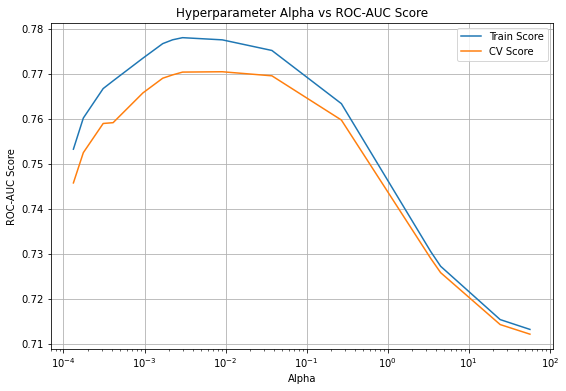

In [47]:
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

In [48]:
def tune_threshold(true_labels, predicted_probas):
    fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
    j_stat = tpr - fpr
    index_for_best_threshold = np.argmax(j_stat)
    
    return threshold[index_for_best_threshold]
def proba_to_class(proba, threshold):
        return np.where(proba >= threshold, 1, 0)

In [49]:
cv_preds_probas = np.zeros(x_train.shape[0])
best_threshold_train = 0
for fold_number, (train_indices, val_indices) in enumerate(kfolds.split(x_train, y_train), 1):
#     print(train_indices)
#     print(x_train[train_indices],y_train[train_indices])
    best_model.fit(x_train[train_indices], y_train[train_indices])
    train_preds_probas = best_model.predict_proba(x_train[train_indices])[:,1]
    cv_preds_probas[val_indices] = best_model.predict_proba(x_train[val_indices])[:,1]
    #tuning the threshold for optimal TPR and FPR from ROC Curve
    best_threshold_train += tune_threshold(y_train[train_indices], train_preds_probas) / num_folds

#converting the class probabilities to class labels
cv_preds_class = proba_to_class(cv_preds_probas, best_threshold_train)

In [50]:
cv_preds_probas

array([0.94733845, 0.04200748, 0.28509566, ..., 0.36481793, 0.37046558,
       0.58431052])

In [51]:
best_model.fit(x_train, y_train)
train_preds_probas = best_model.predict_proba(x_train)[:,1]
test_preds_probas = best_model.predict_proba(x_test_std)[:,1]
train_preds_class = proba_to_class(train_preds_probas, best_threshold_train)
test_preds_class = proba_to_class(test_preds_probas, best_threshold_train)
feat_imp = best_model.coef_[0]

Train Results:
	ROC-AUC Score = 0.7708451696953421


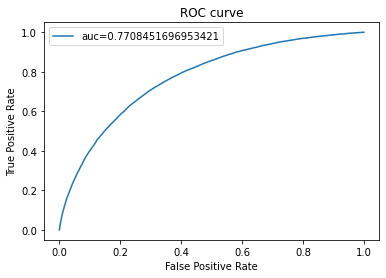

In [52]:
print("Train Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_train, cv_preds_probas)}")
fpr, tpr, thresh= roc_curve(y_train, cv_preds_probas)
auc = roc_auc_score(y_train, cv_preds_probas)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)

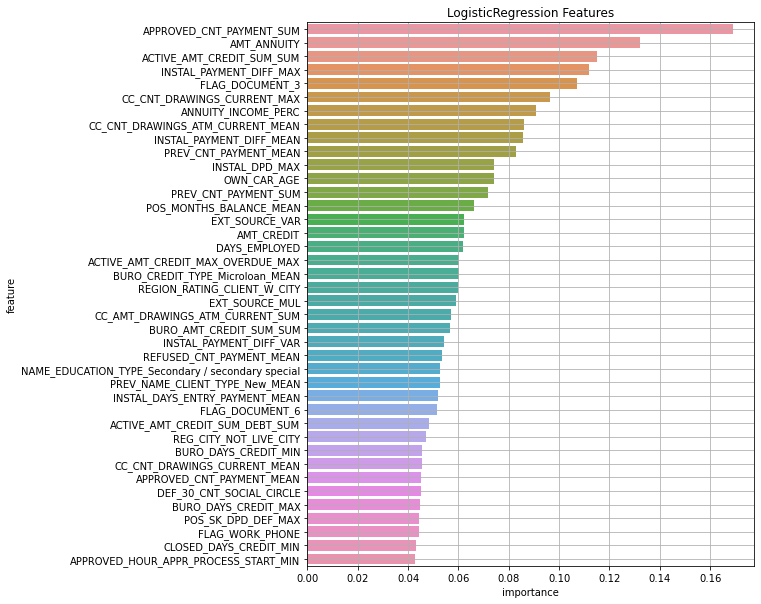

In [53]:
top_feats_indices = np.argsort(feat_imp)[::-1][:40]
feat_importance_top = feat_imp[top_feats_indices]
column_names = train_data.columns[top_feats_indices]

#plotting a horizontal bar plot of feature importances
plt.figure(figsize=(8, 10))
sns.barplot(feat_importance_top, list(range(40)), orient = 'h')
plt.yticks(list(range(40)), column_names)
plt.title('LogisticRegression Features')
plt.xlabel('importance')
plt.ylabel('feature')
plt.grid()
plt.show()

In [54]:
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : test_preds_probas}).to_csv('LR_L2.csv',index = False)

In [55]:
# with open('LR_L2_CV_Preds', 'wb') as f:
#     pickle.dump(cv_preds_probas, f)
pd.DataFrame(cv_preds_probas).to_csv('LR_L2_CV_Preds.csv',index = False)

## Method2: LGBM

In [56]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [57]:
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
def LGBM1(data, num_folds, stratified = False, output= False):
    #Process the name of factor and change it to Json standard format
    data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = data[data['TARGET'].notnull()]
    test_df = data[data['TARGET'].isnull()]
    del data
    gc.collect()
    # Cross validation model
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=30,
            colsample_bytree=0.5623846988471933,
            subsample=0.7643564570786301,
            max_depth=8,
            reg_alpha=0.1449957807440182,
            reg_lambda=0.143599499521874,
            min_split_gain=0.0028740721166233053,
            min_child_weight=73.14919286273387,
            min_child_samples=57,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if output:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('lgbm1.csv', index = False)
    display_importances(feature_importance_df)
    return feature_importance_df,oof_preds

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.794726	training's binary_logloss: 0.235763	valid_1's auc: 0.778918	valid_1's binary_logloss: 0.246228
[400]	training's auc: 0.814614	training's binary_logloss: 0.227122	valid_1's auc: 0.789206	valid_1's binary_logloss: 0.242097
[600]	training's auc: 0.827061	training's binary_logloss: 0.222028	valid_1's auc: 0.792967	valid_1's binary_logloss: 0.240742
[800]	training's auc: 0.837499	training's binary_logloss: 0.217842	valid_1's auc: 0.794824	valid_1's binary_logloss: 0.240112
[1000]	training's auc: 0.846708	training's binary_logloss: 0.214137	valid_1's auc: 0.795885	valid_1's binary_logloss: 0.239785
[1200]	training's auc: 0.854645	training's binary_logloss: 0.210781	valid_1's auc: 0.796552	valid_1's binary_logloss: 0.239556
[1400]	training's auc: 0.862347	training's binary_logloss: 0.207488	valid_1's auc: 0.797177	valid_1's binary_logloss: 0.239361
[1

[1600]	training's auc: 0.870463	training's binary_logloss: 0.204571	valid_1's auc: 0.792441	valid_1's binary_logloss: 0.233605
[1800]	training's auc: 0.87727	training's binary_logloss: 0.201436	valid_1's auc: 0.79243	valid_1's binary_logloss: 0.233622
Fold  7 AUC : 0.792536
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.795181	training's binary_logloss: 0.236014	valid_1's auc: 0.771389	valid_1's binary_logloss: 0.244988
[400]	training's auc: 0.814927	training's binary_logloss: 0.227441	valid_1's auc: 0.781578	valid_1's binary_logloss: 0.240889
[600]	training's auc: 0.82736	training's binary_logloss: 0.222278	valid_1's auc: 0.785827	valid_1's binary_logloss: 0.239373
[800]	training's auc: 0.837542	training's binary_logloss: 0.218109	valid_1's auc: 0.787873	valid_1's binary_logloss: 0.238695
[1000]	training's auc: 0.84642	training's binary_logloss: 0.214433	valid_1's auc: 0.788915	valid_1's binary_l

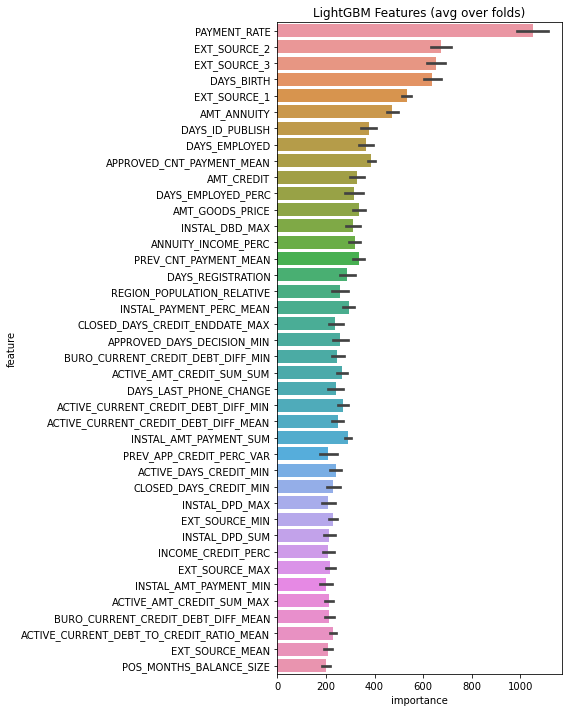

In [58]:
feature_importance_df,oof_preds = LGBM1(app_train, num_folds= 10, stratified= False, output= True)

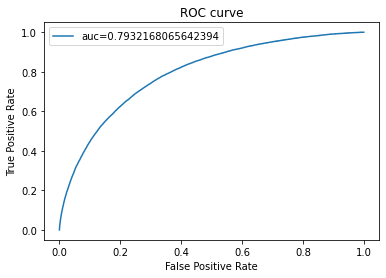

In [59]:
train_df = app_train[app_train['TARGET'].notnull()]
fpr, tpr, thresh= roc_curve(train_df['TARGET'], oof_preds)
auc = roc_auc_score(train_df['TARGET'], oof_preds)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)

In [60]:
df_best20 = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:25]
df_best20

,importance
feature,
PAYMENT_RATE,1049.7
EXT_SOURCE_2,673.7
EXT_SOURCE_3,651.4
DAYS_BIRTH,635.6
EXT_SOURCE_1,531.5
AMT_ANNUITY,473.3
APPROVED_CNT_PAYMENT_MEAN,386.7
DAYS_ID_PUBLISH,377.0
DAYS_EMPLOYED,365.6


In [61]:
pd.DataFrame(oof_preds).to_csv('lgbm_cv_Preds.csv',index = False)

In [62]:
zero_features = list(feature_importance_df[feature_importance_df['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

There are 2187 features with 0.0 importance


In [63]:
feature_importance_df

,feature,importance,fold
0,CODE_GENDER,178,1
1,FLAG_OWN_CAR,7,1
2,FLAG_OWN_REALTY,11,1
3,CNT_CHILDREN,2,1
4,AMT_INCOME_TOTAL,91,1
...,...,...,...
828,CC_NAME_CONTRACT_STATUS_Signed_MAX,0,10
829,CC_NAME_CONTRACT_STATUS_Signed_MEAN,3,10
830,CC_NAME_CONTRACT_STATUS_Signed_SUM,0,10
831,CC_NAME_CONTRACT_STATUS_Signed_VAR,17,10


## Method3: XGBOOST
### The Python code for variable filtering using feature_importance is as follows.

In [64]:
from xgboost import XGBClassifier 
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import roc_curve,auc,roc_auc_score 
data_xgb=app_train[app_train['TARGET'].notnull()]
data_xgb = data_xgb.fillna(-9999)
X_columns = data_xgb.columns[3:] 
Y_columns = ['TARGET'] 

X_train,X_test,y_train,y_test = train_test_split(data_xgb[X_columns],data_xgb[Y_columns],test_size=0.3,random_state=0)

In [65]:
X_matrix_train = X_train.values
Y_matrix_train = y_train.values
X_matrix_test = X_test.values
Y_matrix_test = y_test.values
xgb_clf = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_child_weight=10,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',seed=0,n_jobs=-1)

xgb_clf.fit(X_matrix_train,Y_matrix_train,eval_metric='auc')
y_pred = xgb_clf.predict_proba(X_matrix_test)[:,1]
fpr,tpr,threshold = roc_curve(Y_matrix_test,y_pred)
roc_auc = auc(fpr,tpr)
print('test auc: %f' %roc_auc)

test auc: 0.782775


In [66]:
threshold = np.sort(xgb_clf.feature_importances_) 

### Observing the model effect on the test set under different numbers of incoming model features, the final importance threshold is determined to be 0.0024, and there are 149 incoming model features.

In [67]:
for thresh in threshold[500:800:20]: 
    selection = SelectFromModel(xgb_clf, threshold=thresh, prefit=True) 
    X_train_selection = selection.transform(X_matrix_train) 
    selection_model = XGBClassifier(objective='binary:logistic',learning_rate=0.1,n_estimators=100, max_depth=5,min_child_weight=10,subsample=0.8,colsample_bytree=0.8, seed=0,n_jobs=-1) 
    selection_model.fit(X_train_selection,Y_matrix_train,eval_metric='auc') 
    X_test_selection = selection.transform(X_matrix_test) 
    y_pred = selection_model.predict_proba(X_test_selection)[:,1] 
    fpr,tpr,threshold = roc_curve(Y_matrix_test,y_pred) 
    roc_auc = auc(fpr,tpr)
    print('thresh=%.4f, n=%d, test auc: %f' % (thresh,X_train_selection. shape[1],roc_auc))

thresh=0.0014, n=333, test auc: 0.781486
thresh=0.0015, n=313, test auc: 0.783425
thresh=0.0016, n=293, test auc: 0.783110
thresh=0.0016, n=273, test auc: 0.783613
thresh=0.0017, n=253, test auc: 0.784062
thresh=0.0019, n=233, test auc: 0.782755
thresh=0.0020, n=213, test auc: 0.782928
thresh=0.0021, n=193, test auc: 0.783102
thresh=0.0022, n=173, test auc: 0.783348
thresh=0.0024, n=153, test auc: 0.783857
thresh=0.0025, n=133, test auc: 0.782583
thresh=0.0027, n=113, test auc: 0.782479
thresh=0.0030, n=93, test auc: 0.782158
thresh=0.0034, n=73, test auc: 0.779450
thresh=0.0039, n=53, test auc: 0.777420


In [68]:
feature_importances = pd.DataFrame(xgb_clf.feature_importances_,columns=['importance'])
feature_importances['feature'] = X_columns
feature_importances = feature_importances.sort_values(by='importance',ascending=False)
columns_select = feature_importances.loc[feature_importances['importance']>0.0024,'feature'].tolist()
data_xgb = data_xgb[['SK_ID_CURR','TARGET']+columns_select]
data_xgb.shape

(307507, 151)

In [69]:
data_xgb

,SK_ID_CURR,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Revolving loans,EXT_SOURCE_MIN,FLAG_DOCUMENT_3,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Working,...,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,PREV_CNT_PAYMENT_SUM,CLOSED_AMT_CREDIT_SUM_SUM,ANNUITY_INCOME_PERC,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,EXT_SOURCE_VAR,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,FLOORSMIN_MODE,BURO_CURRENT_CREDIT_DEBT_DIFF_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM
0,100002,1.0,0.262949,0.139376,0,0.083037,1,0,1,1,...,-9999.0,24.0,383067.0,0.121978,40.500,0.005646,245781.00,0.1250,98388.51300,245781.00
1,100003,0.0,0.622246,-9999.000000,0,0.311267,1,1,0,0,...,-9999.0,30.0,207400.5,0.132217,0.000,-9999.000000,0.00,0.3333,254350.12500,0.00
2,100004,0.0,0.555912,0.729567,1,-9999.000000,0,0,1,1,...,-9999.0,4.0,189037.8,0.100000,-9999.000,-9999.000000,-9999.00,-9999.0000,94518.90000,0.00
3,100006,0.0,0.650442,-9999.000000,0,-9999.000000,1,0,1,1,...,-9999.0,138.0,-9999.0,0.219900,-9999.000,-9999.000000,-9999.00,-9999.0000,-9999.00000,-9999.00
4,100007,0.0,0.322738,-9999.000000,0,-9999.000000,0,0,1,1,...,-9999.0,124.0,146250.0,0.179963,-9999.000,-9999.000000,-9999.00,-9999.0000,146250.00000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0.681632,-9999.000000,0,0.145570,0,0,1,1,...,-9999.0,8.0,-9999.0,0.174971,-9999.000,-9999.000000,-9999.00,0.0417,-9999.00000,-9999.00
307503,456252,0.0,0.115992,-9999.000000,0,-9999.000000,1,0,1,0,...,-9999.0,6.0,-9999.0,0.166687,-9999.000,-9999.000000,-9999.00,0.1250,-9999.00000,-9999.00
307504,456253,0.0,0.535722,0.218859,0,0.218859,1,1,0,1,...,-9999.0,10.0,1350000.0,0.195941,-9999.000,0.046621,1795833.00,0.2083,541041.75000,1795833.00
307505,456254,1.0,0.514163,0.661024,0,-9999.000000,1,0,1,0,...,-9999.0,30.0,45000.0,0.118158,-9999.000,-9999.000000,-9999.00,-9999.0000,45000.00000,0.00


### Using Bayesian optimization, the globally optimal hyperparameter combination can be obtained.

In [70]:
from hyperopt import fmin,tpe,hp,partial 
X_columns = data_xgb.columns[2:]
Y_columns = ['TARGET']
X_train,X_test,y_train,y_test = train_test_split(data_xgb[X_columns],data_xgb[Y_columns],test_size=0.3,random_state=0)
X_matrix_train = X_train.values
Y_matrix_train = y_train.values
X_matrix_test = X_test.values
Y_matrix_test = y_test.values 
eval_set = [(X_matrix_train,Y_matrix_train),(X_matrix_test,Y_matrix_test)]

#Define the hyperparameter space
space = {'max_depth': hp.randint('max_depth',2), 
         'n_estimators': hp.randint('n_estimators',1500), 
         'learning_rate': hp.randint('learning_rate',50), 
         'min_child_weight': hp.randint('min_child_weight',100), 
         'subsample': hp.randint('subsample',5), 
         'colsample_bytree': hp.randint('colsample_bytree',5), 
         'alpha': hp.randint('alpha',1000), 
         'lambda': hp.randint('lambda',1000), 
        }
def argsDict_transform(argsDict, isPrint=False): 
    argsDict['max_depth'] = argsDict['max_depth'] + 4 
    argsDict['n_estimators'] = argsDict['n_estimators'] + 500 
    argsDict['learning_rate'] = argsDict['learning_rate'] * 0.01 + 0.01 
    argsDict['min_child_weight'] = argsDict['min_child_weight'] + 1 
    argsDict['subsample'] = argsDict['subsample'] * 0.1 + 0.5 
    argsDict['colsample_bytree'] = argsDict['colsample_bytree'] * 0.1 + 0.5 
    argsDict['alpha'] = argsDict['alpha'] * 0.01 
    argsDict['lambda'] = argsDict['lambda'] * 0.01 
    if isPrint: 
        print(argsDict) 
    else: 
        pass 
    return argsDict

In [71]:
#define metric
def auc_neg(y_pred, dtrain): 
    y_true = dtrain.get_label() 
    fpr,tpr,thresholds = roc_curve(y_true,y_pred) 
    auc_neg = -auc(fpr,tpr) 
    return 'auc_neg', auc_neg 

#Define the training process
def xgboost_factory(argsDict): 
    argsDict = argsDict_transform(argsDict) 
    params = {'max_depth': argsDict['max_depth'], 
              'n_estimators': argsDict['n_estimators'], 
              'learning_rate': argsDict['learning_rate'], 
              'min_child_weight': argsDict['min_child_weight'], 
              'subsample': argsDict['subsample'], 
              'colsample_bytree': argsDict['colsample_bytree'], 
              'objective': 'binary:logistic', 
              'silent': True, 
              'alpha': argsDict['alpha'], 
              'lambda': argsDict['lambda'], 
              'seed': 0 
             } 
    xgb_clf = XGBClassifier(**params) 
    xgb_clf = xgb_clf.fit(X_matrix_train,Y_matrix_train,eval_set=eval_set,eval_metric=auc_neg,early_stopping_rounds=100,verbose=10) 
    return get_transformer_score(xgb_clf)
def get_transformer_score(transformer):
    xgb_clf = transformer
    y_pred = xgb_clf.predict_proba(X_matrix_test,ntree_limit=xgb_clf.best_ntree_limit)[:,1]
    fpr,tpr,threshold = roc_curve(Y_matrix_test,y_pred)
    return -auc(fpr,tpr)

In [72]:
#Search for optimal hyperparameter combination
algo = partial(tpe.suggest, n_startup_jobs=1)
best = fmin(xgboost_factory, space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None)


[12:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.44202	validation_0-auc_neg:-0.68444	validation_1-logloss:0.44221	validation_1-auc_neg:-0.68021
[10]	validation_0-logloss:0.24655	validation_0-auc_neg:-0.76254	validation_1-logloss:0.24800	validation_1-auc_neg:-0.75623
[20]	validation_0-logloss:0.23968	validation_0-auc_neg:-0.77990	validation_1-logloss:0.24307	validation_1-auc_neg:-0.76857
[30]	validation_0-logloss:0.23648	validation_0-auc_neg:-0.78856	validation_1-logloss:0.24151	validation_1-auc_neg:-0.77345
[40]	validation_0-logloss:0.23432	validation_0-auc_neg:-0.79441	validation_1-logloss:0.24126	v

[60]	validation_0-logloss:0.23304	validation_0-auc_neg:-0.79873	validation_1-logloss:0.23858	validation_1-auc_neg:-0.78246
[70]	validation_0-logloss:0.23171	validation_0-auc_neg:-0.80231	validation_1-logloss:0.23831	validation_1-auc_neg:-0.78334
[80]	validation_0-logloss:0.23074	validation_0-auc_neg:-0.80461	validation_1-logloss:0.23802	validation_1-auc_neg:-0.78418
[90]	validation_0-logloss:0.22987	validation_0-auc_neg:-0.80689	validation_1-logloss:0.23799	validation_1-auc_neg:-0.78411
[99]	validation_0-logloss:0.22917	validation_0-auc_neg:-0.80876	validation_1-logloss:0.23796	validation_1-auc_neg:-0.78422
[12:03:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue 

[10]	validation_0-logloss:0.25369	validation_0-auc_neg:-0.76034	validation_1-logloss:0.25542	validation_1-auc_neg:-0.75013
[20]	validation_0-logloss:0.23998	validation_0-auc_neg:-0.78353	validation_1-logloss:0.24444	validation_1-auc_neg:-0.76710
[30]	validation_0-logloss:0.23461	validation_0-auc_neg:-0.79632	validation_1-logloss:0.24106	validation_1-auc_neg:-0.77572
[40]	validation_0-logloss:0.23083	validation_0-auc_neg:-0.80566	validation_1-logloss:0.23963	validation_1-auc_neg:-0.77967
[50]	validation_0-logloss:0.22833	validation_0-auc_neg:-0.81178	validation_1-logloss:0.23898	validation_1-auc_neg:-0.78161
[60]	validation_0-logloss:0.22618	validation_0-auc_neg:-0.81720	validation_1-logloss:0.23850	validation_1-auc_neg:-0.78318
[70]	validation_0-logloss:0.22404	validation_0-auc_neg:-0.82210	validation_1-logloss:0.23793	validation_1-auc_neg:-0.78498
[80]	validation_0-logloss:0.22228	validation_0-auc_neg:-0.82652	validation_1-logloss:0.23780	validation_1-auc_neg:-0.78541
[90]	validation_

[50]	validation_0-logloss:0.23419	validation_0-auc_neg:-0.79619	validation_1-logloss:0.23963	validation_1-auc_neg:-0.78026
[60]	validation_0-logloss:0.23239	validation_0-auc_neg:-0.80063	validation_1-logloss:0.23877	validation_1-auc_neg:-0.78272
[70]	validation_0-logloss:0.23100	validation_0-auc_neg:-0.80439	validation_1-logloss:0.23818	validation_1-auc_neg:-0.78443
[80]	validation_0-logloss:0.22977	validation_0-auc_neg:-0.80722	validation_1-logloss:0.23788	validation_1-auc_neg:-0.78535
[90]	validation_0-logloss:0.22879	validation_0-auc_neg:-0.80980	validation_1-logloss:0.23762	validation_1-auc_neg:-0.78621
[100]	validation_0-logloss:0.22775	validation_0-auc_neg:-0.81244	validation_1-logloss:0.23725	validation_1-auc_neg:-0.78740
[12:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly 

In [73]:
best

{'alpha': 244,
 'colsample_bytree': 3,
 'lambda': 153,
 'learning_rate': 23,
 'max_depth': 0,
 'min_child_weight': 71,
 'n_estimators': 287,
 'subsample': 4}

In [74]:
best = {'alpha': 29,
 'colsample_bytree': 4,
 'lambda': 34,
 'learning_rate': 1,
 'max_depth': 1,
 'min_child_weight': 9,
 'n_estimators': 1325,
 'subsample': 4}

In [75]:
argsDict = argsDict_transform(best) 
params = {'max_depth': argsDict['max_depth'], 
          'n_estimators': argsDict['n_estimators'], 
          'learning_rate': argsDict['learning_rate'], 
          'min_child_weight': argsDict['min_child_weight'], 
          'subsample': argsDict['subsample'], 
          'colsample_bytree': argsDict['colsample_bytree'], 
          'objective': 'binary:logistic', 
          'silent': True, 
          'alpha': argsDict['alpha'], 
          'lambda': argsDict['lambda'], 
          'seed': 0 
         }
params
#加入早停条件 
# xgb_clf = XGBClassifier(**params) 
# xgb_clf = xgb_clf.fit(X_matrix_train,Y_matrix_train,eval_set=eval_set,eval_metric=auc_neg,early_stopping_rounds=100,verbose=10)

{'max_depth': 5,
 'n_estimators': 1825,
 'learning_rate': 0.02,
 'min_child_weight': 10,
 'subsample': 0.9,
 'colsample_bytree': 0.9,
 'objective': 'binary:logistic',
 'silent': True,
 'alpha': 0.29,
 'lambda': 0.34,
 'seed': 0}

In [76]:
params={'max_depth': 9,
 'n_estimators': 2325,
 'learning_rate': 0.0102,
 'min_child_weight': 11,
 'subsample': 0.59,
 'colsample_bytree': 0.59,
 'objective': 'binary:logistic',
 'silent': True,
 'alpha': 0.0029,
 'lambda': 0.0034000000000000002,
 'seed': 0}

In [77]:
def proba_to_class(proba, threshold):
    return np.where(proba >= threshold, 1, 0)
def tune_threshold(true_labels, predicted_probas):
    fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
    j_stat = tpr - fpr
    index_for_best_threshold = np.argmax(j_stat)
    
    return threshold[index_for_best_threshold]

In [78]:
X_columns = data_xgb.columns[2:]
Y_columns = ['TARGET']
x_train=data_xgb[X_columns]
y_train=target_train

test_data = app_train[app_train['TARGET'].isnull()]
skid_test = test_data.pop('SK_ID_CURR')
test_data = test_data.drop(['TARGET'], axis = 1)

x_test=test_data[columns_select]
num_folds=5
random_state = 98
stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
train_preds_proba_mean = np.zeros(x_train.shape[0])
#out-of-fold cv predictions
cv_preds_proba = np.zeros(x_train.shape[0])
test_preds_proba_mean = np.zeros(test_data.shape[0])
#best threshold will be 
best_threshold_train = 0
feature_importance = pd.DataFrame()
feature_importance['features'] = x_train.columns
feature_importance['gain'] = np.zeros(x_train.shape[1])

In [79]:
for fold_number, (train_indices, cv_indices) in enumerate(stratified_cv.split(x_train, y_train), 1):
    x_tr = x_train.iloc[train_indices]
    y_tr = y_train.iloc[train_indices]
    x_cv = x_train.iloc[cv_indices]
    y_cv = y_train.iloc[cv_indices]

    clf = XGBClassifier(**params)
    clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',early_stopping_rounds = 200)
    train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (num_folds - 1)
    cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
    test_preds_proba_mean += clf.predict_proba(x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / num_folds
    #feature importance
    gain_fold = clf.get_booster().get_score(importance_type = 'gain')
    feat_imp = pd.DataFrame()
    feat_imp['features'] = gain_fold.keys()
    feat_imp['gain'] = gain_fold.values()
    best_threshold_train += tune_threshold(y_train[train_indices], train_preds_proba_mean[train_indices]) / num_folds
    feature_importance = pd.concat([feature_importance, feat_imp], axis = 0)

[12:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.74284	validation_1-auc:0.70931
[1]	validation_0-auc:0.76529	validation_1-auc:0.72733
[2]	validation_0-auc:0.77772	validation_1-auc:0.73797
[3]	validation_0-auc:0.78458	validation_1-auc:0.74213
[4]	validation_0-auc:0.78902	validation_1-auc:0.74626
[5]	validation_0-auc:0.79153	validation_1-auc:0.74950
[6]	validation_0-auc:0.79447	validation_1-auc:0.75076
[7]	validation_0-auc:0.79577	validation_1-auc:0.75126
[8]	validation_0-auc:0.79769	validation_1-auc:0.75401
[9]	validation_0-auc:0.79886	validation_1-auc:0.75598
[10]	validation_0-auc:0.79980	validation_1-au

[141]	validation_0-auc:0.82206	validation_1-auc:0.77165
[142]	validation_0-auc:0.82210	validation_1-auc:0.77165
[143]	validation_0-auc:0.82219	validation_1-auc:0.77173
[144]	validation_0-auc:0.82226	validation_1-auc:0.77176
[145]	validation_0-auc:0.82241	validation_1-auc:0.77176
[146]	validation_0-auc:0.82251	validation_1-auc:0.77175
[147]	validation_0-auc:0.82258	validation_1-auc:0.77174
[148]	validation_0-auc:0.82259	validation_1-auc:0.77178
[149]	validation_0-auc:0.82266	validation_1-auc:0.77179
[150]	validation_0-auc:0.82278	validation_1-auc:0.77177
[151]	validation_0-auc:0.82290	validation_1-auc:0.77177
[152]	validation_0-auc:0.82308	validation_1-auc:0.77186
[153]	validation_0-auc:0.82329	validation_1-auc:0.77197
[154]	validation_0-auc:0.82338	validation_1-auc:0.77197
[155]	validation_0-auc:0.82350	validation_1-auc:0.77199
[156]	validation_0-auc:0.82356	validation_1-auc:0.77205
[157]	validation_0-auc:0.82352	validation_1-auc:0.77201
[158]	validation_0-auc:0.82359	validation_1-auc:

[288]	validation_0-auc:0.83830	validation_1-auc:0.77801
[289]	validation_0-auc:0.83848	validation_1-auc:0.77807
[290]	validation_0-auc:0.83863	validation_1-auc:0.77813
[291]	validation_0-auc:0.83875	validation_1-auc:0.77816
[292]	validation_0-auc:0.83889	validation_1-auc:0.77819
[293]	validation_0-auc:0.83901	validation_1-auc:0.77820
[294]	validation_0-auc:0.83916	validation_1-auc:0.77826
[295]	validation_0-auc:0.83935	validation_1-auc:0.77832
[296]	validation_0-auc:0.83945	validation_1-auc:0.77832
[297]	validation_0-auc:0.83966	validation_1-auc:0.77838
[298]	validation_0-auc:0.83984	validation_1-auc:0.77841
[299]	validation_0-auc:0.83994	validation_1-auc:0.77847
[300]	validation_0-auc:0.84010	validation_1-auc:0.77854
[301]	validation_0-auc:0.84023	validation_1-auc:0.77858
[302]	validation_0-auc:0.84032	validation_1-auc:0.77860
[303]	validation_0-auc:0.84042	validation_1-auc:0.77862
[304]	validation_0-auc:0.84055	validation_1-auc:0.77863
[305]	validation_0-auc:0.84068	validation_1-auc:

[435]	validation_0-auc:0.85669	validation_1-auc:0.78373
[436]	validation_0-auc:0.85682	validation_1-auc:0.78376
[437]	validation_0-auc:0.85694	validation_1-auc:0.78378
[438]	validation_0-auc:0.85704	validation_1-auc:0.78380
[439]	validation_0-auc:0.85717	validation_1-auc:0.78386
[440]	validation_0-auc:0.85730	validation_1-auc:0.78392
[441]	validation_0-auc:0.85739	validation_1-auc:0.78395
[442]	validation_0-auc:0.85745	validation_1-auc:0.78395
[443]	validation_0-auc:0.85754	validation_1-auc:0.78398
[444]	validation_0-auc:0.85762	validation_1-auc:0.78398
[445]	validation_0-auc:0.85773	validation_1-auc:0.78402
[446]	validation_0-auc:0.85782	validation_1-auc:0.78403
[447]	validation_0-auc:0.85790	validation_1-auc:0.78406
[448]	validation_0-auc:0.85797	validation_1-auc:0.78405
[449]	validation_0-auc:0.85810	validation_1-auc:0.78410
[450]	validation_0-auc:0.85821	validation_1-auc:0.78411
[451]	validation_0-auc:0.85830	validation_1-auc:0.78415
[452]	validation_0-auc:0.85844	validation_1-auc:

[582]	validation_0-auc:0.87079	validation_1-auc:0.78764
[583]	validation_0-auc:0.87085	validation_1-auc:0.78767
[584]	validation_0-auc:0.87090	validation_1-auc:0.78769
[585]	validation_0-auc:0.87100	validation_1-auc:0.78771
[586]	validation_0-auc:0.87109	validation_1-auc:0.78774
[587]	validation_0-auc:0.87116	validation_1-auc:0.78775
[588]	validation_0-auc:0.87126	validation_1-auc:0.78777
[589]	validation_0-auc:0.87139	validation_1-auc:0.78782
[590]	validation_0-auc:0.87152	validation_1-auc:0.78789
[591]	validation_0-auc:0.87161	validation_1-auc:0.78790
[592]	validation_0-auc:0.87167	validation_1-auc:0.78793
[593]	validation_0-auc:0.87178	validation_1-auc:0.78794
[594]	validation_0-auc:0.87183	validation_1-auc:0.78798
[595]	validation_0-auc:0.87191	validation_1-auc:0.78800
[596]	validation_0-auc:0.87203	validation_1-auc:0.78802
[597]	validation_0-auc:0.87214	validation_1-auc:0.78804
[598]	validation_0-auc:0.87222	validation_1-auc:0.78807
[599]	validation_0-auc:0.87229	validation_1-auc:

[729]	validation_0-auc:0.88141	validation_1-auc:0.79006
[730]	validation_0-auc:0.88147	validation_1-auc:0.79003
[731]	validation_0-auc:0.88152	validation_1-auc:0.79005
[732]	validation_0-auc:0.88157	validation_1-auc:0.79006
[733]	validation_0-auc:0.88166	validation_1-auc:0.79007
[734]	validation_0-auc:0.88176	validation_1-auc:0.79007
[735]	validation_0-auc:0.88180	validation_1-auc:0.79009
[736]	validation_0-auc:0.88190	validation_1-auc:0.79008
[737]	validation_0-auc:0.88195	validation_1-auc:0.79010
[738]	validation_0-auc:0.88200	validation_1-auc:0.79010
[739]	validation_0-auc:0.88210	validation_1-auc:0.79012
[740]	validation_0-auc:0.88219	validation_1-auc:0.79014
[741]	validation_0-auc:0.88222	validation_1-auc:0.79015
[742]	validation_0-auc:0.88233	validation_1-auc:0.79018
[743]	validation_0-auc:0.88235	validation_1-auc:0.79018
[744]	validation_0-auc:0.88241	validation_1-auc:0.79017
[745]	validation_0-auc:0.88254	validation_1-auc:0.79021
[746]	validation_0-auc:0.88257	validation_1-auc:

[876]	validation_0-auc:0.88975	validation_1-auc:0.79129
[877]	validation_0-auc:0.88979	validation_1-auc:0.79132
[878]	validation_0-auc:0.88987	validation_1-auc:0.79132
[879]	validation_0-auc:0.88995	validation_1-auc:0.79135
[880]	validation_0-auc:0.88999	validation_1-auc:0.79137
[881]	validation_0-auc:0.89006	validation_1-auc:0.79138
[882]	validation_0-auc:0.89011	validation_1-auc:0.79140
[883]	validation_0-auc:0.89014	validation_1-auc:0.79142
[884]	validation_0-auc:0.89024	validation_1-auc:0.79143
[885]	validation_0-auc:0.89027	validation_1-auc:0.79142
[886]	validation_0-auc:0.89031	validation_1-auc:0.79143
[887]	validation_0-auc:0.89032	validation_1-auc:0.79143
[888]	validation_0-auc:0.89036	validation_1-auc:0.79144
[889]	validation_0-auc:0.89042	validation_1-auc:0.79144
[890]	validation_0-auc:0.89045	validation_1-auc:0.79146
[891]	validation_0-auc:0.89050	validation_1-auc:0.79145
[892]	validation_0-auc:0.89054	validation_1-auc:0.79147
[893]	validation_0-auc:0.89061	validation_1-auc:

[1022]	validation_0-auc:0.89746	validation_1-auc:0.79219
[1023]	validation_0-auc:0.89751	validation_1-auc:0.79220
[1024]	validation_0-auc:0.89758	validation_1-auc:0.79219
[1025]	validation_0-auc:0.89767	validation_1-auc:0.79221
[1026]	validation_0-auc:0.89770	validation_1-auc:0.79221
[1027]	validation_0-auc:0.89777	validation_1-auc:0.79226
[1028]	validation_0-auc:0.89785	validation_1-auc:0.79226
[1029]	validation_0-auc:0.89789	validation_1-auc:0.79226
[1030]	validation_0-auc:0.89792	validation_1-auc:0.79225
[1031]	validation_0-auc:0.89800	validation_1-auc:0.79226
[1032]	validation_0-auc:0.89807	validation_1-auc:0.79226
[1033]	validation_0-auc:0.89808	validation_1-auc:0.79225
[1034]	validation_0-auc:0.89811	validation_1-auc:0.79224
[1035]	validation_0-auc:0.89818	validation_1-auc:0.79224
[1036]	validation_0-auc:0.89819	validation_1-auc:0.79224
[1037]	validation_0-auc:0.89825	validation_1-auc:0.79224
[1038]	validation_0-auc:0.89831	validation_1-auc:0.79226
[1039]	validation_0-auc:0.89835

[1166]	validation_0-auc:0.90388	validation_1-auc:0.79257
[1167]	validation_0-auc:0.90392	validation_1-auc:0.79257
[1168]	validation_0-auc:0.90395	validation_1-auc:0.79257
[1169]	validation_0-auc:0.90401	validation_1-auc:0.79256
[1170]	validation_0-auc:0.90406	validation_1-auc:0.79257
[1171]	validation_0-auc:0.90409	validation_1-auc:0.79256
[1172]	validation_0-auc:0.90414	validation_1-auc:0.79258
[1173]	validation_0-auc:0.90416	validation_1-auc:0.79259
[1174]	validation_0-auc:0.90421	validation_1-auc:0.79260
[1175]	validation_0-auc:0.90425	validation_1-auc:0.79261
[1176]	validation_0-auc:0.90425	validation_1-auc:0.79261
[1177]	validation_0-auc:0.90429	validation_1-auc:0.79262
[1178]	validation_0-auc:0.90434	validation_1-auc:0.79262
[1179]	validation_0-auc:0.90438	validation_1-auc:0.79263
[1180]	validation_0-auc:0.90440	validation_1-auc:0.79262
[1181]	validation_0-auc:0.90445	validation_1-auc:0.79263
[1182]	validation_0-auc:0.90454	validation_1-auc:0.79263
[1183]	validation_0-auc:0.90461

[1310]	validation_0-auc:0.91014	validation_1-auc:0.79279
[1311]	validation_0-auc:0.91017	validation_1-auc:0.79281
[1312]	validation_0-auc:0.91022	validation_1-auc:0.79281
[1313]	validation_0-auc:0.91026	validation_1-auc:0.79281
[1314]	validation_0-auc:0.91030	validation_1-auc:0.79281
[1315]	validation_0-auc:0.91032	validation_1-auc:0.79282
[1316]	validation_0-auc:0.91035	validation_1-auc:0.79282
[1317]	validation_0-auc:0.91040	validation_1-auc:0.79281
[1318]	validation_0-auc:0.91044	validation_1-auc:0.79282
[1319]	validation_0-auc:0.91048	validation_1-auc:0.79282
[1320]	validation_0-auc:0.91052	validation_1-auc:0.79283
[1321]	validation_0-auc:0.91059	validation_1-auc:0.79285
[1322]	validation_0-auc:0.91062	validation_1-auc:0.79285
[1323]	validation_0-auc:0.91068	validation_1-auc:0.79286
[1324]	validation_0-auc:0.91072	validation_1-auc:0.79286
[1325]	validation_0-auc:0.91075	validation_1-auc:0.79286
[1326]	validation_0-auc:0.91078	validation_1-auc:0.79286
[1327]	validation_0-auc:0.91086

[1454]	validation_0-auc:0.91588	validation_1-auc:0.79297
[1455]	validation_0-auc:0.91592	validation_1-auc:0.79298
[1456]	validation_0-auc:0.91599	validation_1-auc:0.79299
[1457]	validation_0-auc:0.91604	validation_1-auc:0.79299
[1458]	validation_0-auc:0.91608	validation_1-auc:0.79300
[1459]	validation_0-auc:0.91612	validation_1-auc:0.79301
[1460]	validation_0-auc:0.91616	validation_1-auc:0.79300
[1461]	validation_0-auc:0.91620	validation_1-auc:0.79302
[1462]	validation_0-auc:0.91622	validation_1-auc:0.79303
[1463]	validation_0-auc:0.91622	validation_1-auc:0.79303
[1464]	validation_0-auc:0.91625	validation_1-auc:0.79304
[1465]	validation_0-auc:0.91633	validation_1-auc:0.79302
[1466]	validation_0-auc:0.91636	validation_1-auc:0.79303
[1467]	validation_0-auc:0.91638	validation_1-auc:0.79302
[1468]	validation_0-auc:0.91642	validation_1-auc:0.79302
[1469]	validation_0-auc:0.91644	validation_1-auc:0.79302
[1470]	validation_0-auc:0.91646	validation_1-auc:0.79303
[1471]	validation_0-auc:0.91650

[1598]	validation_0-auc:0.92108	validation_1-auc:0.79294
[1599]	validation_0-auc:0.92111	validation_1-auc:0.79293
[1600]	validation_0-auc:0.92114	validation_1-auc:0.79294
[1601]	validation_0-auc:0.92117	validation_1-auc:0.79295
[1602]	validation_0-auc:0.92121	validation_1-auc:0.79294
[1603]	validation_0-auc:0.92126	validation_1-auc:0.79294
[1604]	validation_0-auc:0.92132	validation_1-auc:0.79294
[1605]	validation_0-auc:0.92135	validation_1-auc:0.79295
[1606]	validation_0-auc:0.92136	validation_1-auc:0.79294
[1607]	validation_0-auc:0.92139	validation_1-auc:0.79294
[1608]	validation_0-auc:0.92142	validation_1-auc:0.79294
[1609]	validation_0-auc:0.92149	validation_1-auc:0.79296
[1610]	validation_0-auc:0.92151	validation_1-auc:0.79294
[1611]	validation_0-auc:0.92156	validation_1-auc:0.79294
[1612]	validation_0-auc:0.92161	validation_1-auc:0.79293
[1613]	validation_0-auc:0.92163	validation_1-auc:0.79293
[1614]	validation_0-auc:0.92168	validation_1-auc:0.79293
[1615]	validation_0-auc:0.92175

[39]	validation_0-auc:0.81166	validation_1-auc:0.76203
[40]	validation_0-auc:0.81186	validation_1-auc:0.76220
[41]	validation_0-auc:0.81190	validation_1-auc:0.76219
[42]	validation_0-auc:0.81204	validation_1-auc:0.76214
[43]	validation_0-auc:0.81233	validation_1-auc:0.76227
[44]	validation_0-auc:0.81243	validation_1-auc:0.76236
[45]	validation_0-auc:0.81257	validation_1-auc:0.76276
[46]	validation_0-auc:0.81279	validation_1-auc:0.76272
[47]	validation_0-auc:0.81297	validation_1-auc:0.76284
[48]	validation_0-auc:0.81307	validation_1-auc:0.76293
[49]	validation_0-auc:0.81322	validation_1-auc:0.76306
[50]	validation_0-auc:0.81342	validation_1-auc:0.76334
[51]	validation_0-auc:0.81365	validation_1-auc:0.76344
[52]	validation_0-auc:0.81395	validation_1-auc:0.76356
[53]	validation_0-auc:0.81396	validation_1-auc:0.76342
[54]	validation_0-auc:0.81424	validation_1-auc:0.76337
[55]	validation_0-auc:0.81435	validation_1-auc:0.76340
[56]	validation_0-auc:0.81439	validation_1-auc:0.76342
[57]	valid

[187]	validation_0-auc:0.82734	validation_1-auc:0.76874
[188]	validation_0-auc:0.82755	validation_1-auc:0.76882
[189]	validation_0-auc:0.82765	validation_1-auc:0.76881
[190]	validation_0-auc:0.82773	validation_1-auc:0.76886
[191]	validation_0-auc:0.82786	validation_1-auc:0.76901
[192]	validation_0-auc:0.82800	validation_1-auc:0.76907
[193]	validation_0-auc:0.82812	validation_1-auc:0.76909
[194]	validation_0-auc:0.82820	validation_1-auc:0.76910
[195]	validation_0-auc:0.82826	validation_1-auc:0.76913
[196]	validation_0-auc:0.82839	validation_1-auc:0.76919
[197]	validation_0-auc:0.82847	validation_1-auc:0.76918
[198]	validation_0-auc:0.82862	validation_1-auc:0.76922
[199]	validation_0-auc:0.82868	validation_1-auc:0.76920
[200]	validation_0-auc:0.82872	validation_1-auc:0.76922
[201]	validation_0-auc:0.82880	validation_1-auc:0.76924
[202]	validation_0-auc:0.82887	validation_1-auc:0.76930
[203]	validation_0-auc:0.82897	validation_1-auc:0.76936
[204]	validation_0-auc:0.82905	validation_1-auc:

[334]	validation_0-auc:0.84459	validation_1-auc:0.77601
[335]	validation_0-auc:0.84472	validation_1-auc:0.77603
[336]	validation_0-auc:0.84482	validation_1-auc:0.77607
[337]	validation_0-auc:0.84497	validation_1-auc:0.77617
[338]	validation_0-auc:0.84506	validation_1-auc:0.77619
[339]	validation_0-auc:0.84518	validation_1-auc:0.77625
[340]	validation_0-auc:0.84529	validation_1-auc:0.77631
[341]	validation_0-auc:0.84540	validation_1-auc:0.77640
[342]	validation_0-auc:0.84551	validation_1-auc:0.77643
[343]	validation_0-auc:0.84565	validation_1-auc:0.77651
[344]	validation_0-auc:0.84575	validation_1-auc:0.77657
[345]	validation_0-auc:0.84578	validation_1-auc:0.77661
[346]	validation_0-auc:0.84592	validation_1-auc:0.77661
[347]	validation_0-auc:0.84610	validation_1-auc:0.77664
[348]	validation_0-auc:0.84619	validation_1-auc:0.77671
[349]	validation_0-auc:0.84631	validation_1-auc:0.77679
[350]	validation_0-auc:0.84642	validation_1-auc:0.77682
[351]	validation_0-auc:0.84654	validation_1-auc:

[481]	validation_0-auc:0.86021	validation_1-auc:0.78231
[482]	validation_0-auc:0.86033	validation_1-auc:0.78236
[483]	validation_0-auc:0.86042	validation_1-auc:0.78242
[484]	validation_0-auc:0.86050	validation_1-auc:0.78247
[485]	validation_0-auc:0.86068	validation_1-auc:0.78254
[486]	validation_0-auc:0.86074	validation_1-auc:0.78256
[487]	validation_0-auc:0.86084	validation_1-auc:0.78258
[488]	validation_0-auc:0.86088	validation_1-auc:0.78259
[489]	validation_0-auc:0.86097	validation_1-auc:0.78261
[490]	validation_0-auc:0.86108	validation_1-auc:0.78265
[491]	validation_0-auc:0.86118	validation_1-auc:0.78267
[492]	validation_0-auc:0.86125	validation_1-auc:0.78268
[493]	validation_0-auc:0.86135	validation_1-auc:0.78274
[494]	validation_0-auc:0.86143	validation_1-auc:0.78282
[495]	validation_0-auc:0.86151	validation_1-auc:0.78284
[496]	validation_0-auc:0.86162	validation_1-auc:0.78288
[497]	validation_0-auc:0.86178	validation_1-auc:0.78295
[498]	validation_0-auc:0.86187	validation_1-auc:

[628]	validation_0-auc:0.87272	validation_1-auc:0.78661
[629]	validation_0-auc:0.87277	validation_1-auc:0.78663
[630]	validation_0-auc:0.87282	validation_1-auc:0.78665
[631]	validation_0-auc:0.87292	validation_1-auc:0.78667
[632]	validation_0-auc:0.87299	validation_1-auc:0.78668
[633]	validation_0-auc:0.87311	validation_1-auc:0.78673
[634]	validation_0-auc:0.87319	validation_1-auc:0.78678
[635]	validation_0-auc:0.87325	validation_1-auc:0.78682
[636]	validation_0-auc:0.87336	validation_1-auc:0.78685
[637]	validation_0-auc:0.87340	validation_1-auc:0.78686
[638]	validation_0-auc:0.87354	validation_1-auc:0.78687
[639]	validation_0-auc:0.87364	validation_1-auc:0.78691
[640]	validation_0-auc:0.87375	validation_1-auc:0.78693
[641]	validation_0-auc:0.87388	validation_1-auc:0.78693
[642]	validation_0-auc:0.87396	validation_1-auc:0.78694
[643]	validation_0-auc:0.87406	validation_1-auc:0.78696
[644]	validation_0-auc:0.87417	validation_1-auc:0.78698
[645]	validation_0-auc:0.87427	validation_1-auc:

[775]	validation_0-auc:0.88299	validation_1-auc:0.78922
[776]	validation_0-auc:0.88307	validation_1-auc:0.78925
[777]	validation_0-auc:0.88314	validation_1-auc:0.78929
[778]	validation_0-auc:0.88318	validation_1-auc:0.78930
[779]	validation_0-auc:0.88326	validation_1-auc:0.78931
[780]	validation_0-auc:0.88333	validation_1-auc:0.78931
[781]	validation_0-auc:0.88339	validation_1-auc:0.78933
[782]	validation_0-auc:0.88345	validation_1-auc:0.78935
[783]	validation_0-auc:0.88350	validation_1-auc:0.78937
[784]	validation_0-auc:0.88356	validation_1-auc:0.78938
[785]	validation_0-auc:0.88366	validation_1-auc:0.78937
[786]	validation_0-auc:0.88373	validation_1-auc:0.78937
[787]	validation_0-auc:0.88377	validation_1-auc:0.78937
[788]	validation_0-auc:0.88380	validation_1-auc:0.78939
[789]	validation_0-auc:0.88390	validation_1-auc:0.78942
[790]	validation_0-auc:0.88393	validation_1-auc:0.78943
[791]	validation_0-auc:0.88403	validation_1-auc:0.78947
[792]	validation_0-auc:0.88408	validation_1-auc:

[922]	validation_0-auc:0.89153	validation_1-auc:0.79097
[923]	validation_0-auc:0.89163	validation_1-auc:0.79100
[924]	validation_0-auc:0.89170	validation_1-auc:0.79101
[925]	validation_0-auc:0.89176	validation_1-auc:0.79101
[926]	validation_0-auc:0.89183	validation_1-auc:0.79102
[927]	validation_0-auc:0.89191	validation_1-auc:0.79104
[928]	validation_0-auc:0.89202	validation_1-auc:0.79105
[929]	validation_0-auc:0.89209	validation_1-auc:0.79107
[930]	validation_0-auc:0.89213	validation_1-auc:0.79109
[931]	validation_0-auc:0.89220	validation_1-auc:0.79110
[932]	validation_0-auc:0.89221	validation_1-auc:0.79109
[933]	validation_0-auc:0.89224	validation_1-auc:0.79109
[934]	validation_0-auc:0.89230	validation_1-auc:0.79110
[935]	validation_0-auc:0.89237	validation_1-auc:0.79109
[936]	validation_0-auc:0.89239	validation_1-auc:0.79110
[937]	validation_0-auc:0.89244	validation_1-auc:0.79110
[938]	validation_0-auc:0.89251	validation_1-auc:0.79111
[939]	validation_0-auc:0.89252	validation_1-auc:

[1068]	validation_0-auc:0.89887	validation_1-auc:0.79214
[1069]	validation_0-auc:0.89891	validation_1-auc:0.79214
[1070]	validation_0-auc:0.89893	validation_1-auc:0.79214
[1071]	validation_0-auc:0.89900	validation_1-auc:0.79214
[1072]	validation_0-auc:0.89909	validation_1-auc:0.79213
[1073]	validation_0-auc:0.89917	validation_1-auc:0.79218
[1074]	validation_0-auc:0.89921	validation_1-auc:0.79220
[1075]	validation_0-auc:0.89925	validation_1-auc:0.79221
[1076]	validation_0-auc:0.89932	validation_1-auc:0.79222
[1077]	validation_0-auc:0.89935	validation_1-auc:0.79222
[1078]	validation_0-auc:0.89942	validation_1-auc:0.79221
[1079]	validation_0-auc:0.89949	validation_1-auc:0.79223
[1080]	validation_0-auc:0.89957	validation_1-auc:0.79222
[1081]	validation_0-auc:0.89963	validation_1-auc:0.79221
[1082]	validation_0-auc:0.89966	validation_1-auc:0.79223
[1083]	validation_0-auc:0.89972	validation_1-auc:0.79223
[1084]	validation_0-auc:0.89976	validation_1-auc:0.79223
[1085]	validation_0-auc:0.89979

[1212]	validation_0-auc:0.90558	validation_1-auc:0.79275
[1213]	validation_0-auc:0.90562	validation_1-auc:0.79274
[1214]	validation_0-auc:0.90568	validation_1-auc:0.79275
[1215]	validation_0-auc:0.90572	validation_1-auc:0.79274
[1216]	validation_0-auc:0.90577	validation_1-auc:0.79274
[1217]	validation_0-auc:0.90579	validation_1-auc:0.79274
[1218]	validation_0-auc:0.90583	validation_1-auc:0.79274
[1219]	validation_0-auc:0.90592	validation_1-auc:0.79273
[1220]	validation_0-auc:0.90596	validation_1-auc:0.79274
[1221]	validation_0-auc:0.90600	validation_1-auc:0.79274
[1222]	validation_0-auc:0.90606	validation_1-auc:0.79276
[1223]	validation_0-auc:0.90614	validation_1-auc:0.79275
[1224]	validation_0-auc:0.90616	validation_1-auc:0.79276
[1225]	validation_0-auc:0.90624	validation_1-auc:0.79276
[1226]	validation_0-auc:0.90630	validation_1-auc:0.79278
[1227]	validation_0-auc:0.90634	validation_1-auc:0.79280
[1228]	validation_0-auc:0.90640	validation_1-auc:0.79279
[1229]	validation_0-auc:0.90643

[1356]	validation_0-auc:0.91152	validation_1-auc:0.79318
[1357]	validation_0-auc:0.91158	validation_1-auc:0.79319
[1358]	validation_0-auc:0.91161	validation_1-auc:0.79320
[1359]	validation_0-auc:0.91163	validation_1-auc:0.79320
[1360]	validation_0-auc:0.91166	validation_1-auc:0.79320
[1361]	validation_0-auc:0.91172	validation_1-auc:0.79320
[1362]	validation_0-auc:0.91174	validation_1-auc:0.79319
[1363]	validation_0-auc:0.91183	validation_1-auc:0.79321
[1364]	validation_0-auc:0.91185	validation_1-auc:0.79322
[1365]	validation_0-auc:0.91189	validation_1-auc:0.79322
[1366]	validation_0-auc:0.91196	validation_1-auc:0.79323
[1367]	validation_0-auc:0.91198	validation_1-auc:0.79325
[1368]	validation_0-auc:0.91200	validation_1-auc:0.79326
[1369]	validation_0-auc:0.91201	validation_1-auc:0.79326
[1370]	validation_0-auc:0.91206	validation_1-auc:0.79326
[1371]	validation_0-auc:0.91210	validation_1-auc:0.79326
[1372]	validation_0-auc:0.91212	validation_1-auc:0.79327
[1373]	validation_0-auc:0.91216

[1500]	validation_0-auc:0.91692	validation_1-auc:0.79352
[1501]	validation_0-auc:0.91695	validation_1-auc:0.79353
[1502]	validation_0-auc:0.91697	validation_1-auc:0.79353
[1503]	validation_0-auc:0.91699	validation_1-auc:0.79353
[1504]	validation_0-auc:0.91701	validation_1-auc:0.79353
[1505]	validation_0-auc:0.91707	validation_1-auc:0.79354
[1506]	validation_0-auc:0.91708	validation_1-auc:0.79354
[1507]	validation_0-auc:0.91711	validation_1-auc:0.79353
[1508]	validation_0-auc:0.91713	validation_1-auc:0.79354
[1509]	validation_0-auc:0.91717	validation_1-auc:0.79353
[1510]	validation_0-auc:0.91721	validation_1-auc:0.79353
[1511]	validation_0-auc:0.91726	validation_1-auc:0.79354
[1512]	validation_0-auc:0.91728	validation_1-auc:0.79355
[1513]	validation_0-auc:0.91733	validation_1-auc:0.79358
[1514]	validation_0-auc:0.91736	validation_1-auc:0.79358
[1515]	validation_0-auc:0.91738	validation_1-auc:0.79359
[1516]	validation_0-auc:0.91743	validation_1-auc:0.79361
[1517]	validation_0-auc:0.91745

[1644]	validation_0-auc:0.92205	validation_1-auc:0.79380
[1645]	validation_0-auc:0.92210	validation_1-auc:0.79378
[1646]	validation_0-auc:0.92213	validation_1-auc:0.79378
[1647]	validation_0-auc:0.92217	validation_1-auc:0.79378
[1648]	validation_0-auc:0.92221	validation_1-auc:0.79379
[1649]	validation_0-auc:0.92222	validation_1-auc:0.79379
[1650]	validation_0-auc:0.92225	validation_1-auc:0.79379
[1651]	validation_0-auc:0.92227	validation_1-auc:0.79379
[1652]	validation_0-auc:0.92231	validation_1-auc:0.79380
[1653]	validation_0-auc:0.92235	validation_1-auc:0.79379
[1654]	validation_0-auc:0.92237	validation_1-auc:0.79379
[1655]	validation_0-auc:0.92239	validation_1-auc:0.79379
[1656]	validation_0-auc:0.92244	validation_1-auc:0.79378
[1657]	validation_0-auc:0.92248	validation_1-auc:0.79378
[1658]	validation_0-auc:0.92250	validation_1-auc:0.79378
[1659]	validation_0-auc:0.92257	validation_1-auc:0.79378
[1660]	validation_0-auc:0.92262	validation_1-auc:0.79378
[1661]	validation_0-auc:0.92266

[1788]	validation_0-auc:0.92696	validation_1-auc:0.79408
[1789]	validation_0-auc:0.92698	validation_1-auc:0.79407
[1790]	validation_0-auc:0.92703	validation_1-auc:0.79407
[1791]	validation_0-auc:0.92705	validation_1-auc:0.79407
[1792]	validation_0-auc:0.92708	validation_1-auc:0.79408
[1793]	validation_0-auc:0.92711	validation_1-auc:0.79409
[1794]	validation_0-auc:0.92713	validation_1-auc:0.79408
[1795]	validation_0-auc:0.92717	validation_1-auc:0.79407
[1796]	validation_0-auc:0.92722	validation_1-auc:0.79408
[1797]	validation_0-auc:0.92723	validation_1-auc:0.79407
[1798]	validation_0-auc:0.92727	validation_1-auc:0.79406
[1799]	validation_0-auc:0.92733	validation_1-auc:0.79406
[1800]	validation_0-auc:0.92740	validation_1-auc:0.79406
[1801]	validation_0-auc:0.92742	validation_1-auc:0.79405
[1802]	validation_0-auc:0.92744	validation_1-auc:0.79406
[1803]	validation_0-auc:0.92748	validation_1-auc:0.79406
[1804]	validation_0-auc:0.92753	validation_1-auc:0.79406
[1805]	validation_0-auc:0.92755

[1932]	validation_0-auc:0.93144	validation_1-auc:0.79427
[1933]	validation_0-auc:0.93148	validation_1-auc:0.79427
[1934]	validation_0-auc:0.93154	validation_1-auc:0.79426
[1935]	validation_0-auc:0.93156	validation_1-auc:0.79426
[1936]	validation_0-auc:0.93161	validation_1-auc:0.79427
[1937]	validation_0-auc:0.93163	validation_1-auc:0.79428
[1938]	validation_0-auc:0.93167	validation_1-auc:0.79430
[1939]	validation_0-auc:0.93170	validation_1-auc:0.79428
[1940]	validation_0-auc:0.93172	validation_1-auc:0.79427
[1941]	validation_0-auc:0.93174	validation_1-auc:0.79427
[1942]	validation_0-auc:0.93177	validation_1-auc:0.79427
[1943]	validation_0-auc:0.93180	validation_1-auc:0.79427
[1944]	validation_0-auc:0.93181	validation_1-auc:0.79427
[1945]	validation_0-auc:0.93185	validation_1-auc:0.79424
[1946]	validation_0-auc:0.93187	validation_1-auc:0.79424
[1947]	validation_0-auc:0.93190	validation_1-auc:0.79426
[1948]	validation_0-auc:0.93190	validation_1-auc:0.79424
[1949]	validation_0-auc:0.93194

[2076]	validation_0-auc:0.93594	validation_1-auc:0.79448
[2077]	validation_0-auc:0.93597	validation_1-auc:0.79449
[2078]	validation_0-auc:0.93599	validation_1-auc:0.79448
[2079]	validation_0-auc:0.93605	validation_1-auc:0.79448
[2080]	validation_0-auc:0.93606	validation_1-auc:0.79447
[2081]	validation_0-auc:0.93611	validation_1-auc:0.79446
[2082]	validation_0-auc:0.93613	validation_1-auc:0.79447
[2083]	validation_0-auc:0.93614	validation_1-auc:0.79448
[2084]	validation_0-auc:0.93618	validation_1-auc:0.79446
[2085]	validation_0-auc:0.93621	validation_1-auc:0.79446
[2086]	validation_0-auc:0.93623	validation_1-auc:0.79447
[2087]	validation_0-auc:0.93626	validation_1-auc:0.79447
[2088]	validation_0-auc:0.93631	validation_1-auc:0.79446
[2089]	validation_0-auc:0.93633	validation_1-auc:0.79445
[2090]	validation_0-auc:0.93637	validation_1-auc:0.79445
[2091]	validation_0-auc:0.93640	validation_1-auc:0.79444
[2092]	validation_0-auc:0.93643	validation_1-auc:0.79445
[2093]	validation_0-auc:0.93647

[2220]	validation_0-auc:0.93993	validation_1-auc:0.79440
[2221]	validation_0-auc:0.93996	validation_1-auc:0.79441
[2222]	validation_0-auc:0.93999	validation_1-auc:0.79441
[2223]	validation_0-auc:0.94002	validation_1-auc:0.79441
[2224]	validation_0-auc:0.94003	validation_1-auc:0.79444
[2225]	validation_0-auc:0.94006	validation_1-auc:0.79444
[2226]	validation_0-auc:0.94011	validation_1-auc:0.79444
[2227]	validation_0-auc:0.94011	validation_1-auc:0.79444
[2228]	validation_0-auc:0.94012	validation_1-auc:0.79444
[2229]	validation_0-auc:0.94015	validation_1-auc:0.79444
[2230]	validation_0-auc:0.94017	validation_1-auc:0.79444
[2231]	validation_0-auc:0.94022	validation_1-auc:0.79445
[2232]	validation_0-auc:0.94024	validation_1-auc:0.79445
[2233]	validation_0-auc:0.94025	validation_1-auc:0.79445
[2234]	validation_0-auc:0.94029	validation_1-auc:0.79445
[2235]	validation_0-auc:0.94031	validation_1-auc:0.79444
[2236]	validation_0-auc:0.94033	validation_1-auc:0.79446
[2237]	validation_0-auc:0.94035

[33]	validation_0-auc:0.81088	validation_1-auc:0.75649
[34]	validation_0-auc:0.81108	validation_1-auc:0.75641
[35]	validation_0-auc:0.81127	validation_1-auc:0.75632
[36]	validation_0-auc:0.81121	validation_1-auc:0.75626
[37]	validation_0-auc:0.81138	validation_1-auc:0.75627
[38]	validation_0-auc:0.81151	validation_1-auc:0.75637
[39]	validation_0-auc:0.81171	validation_1-auc:0.75663
[40]	validation_0-auc:0.81205	validation_1-auc:0.75703
[41]	validation_0-auc:0.81236	validation_1-auc:0.75685
[42]	validation_0-auc:0.81291	validation_1-auc:0.75737
[43]	validation_0-auc:0.81288	validation_1-auc:0.75728
[44]	validation_0-auc:0.81292	validation_1-auc:0.75715
[45]	validation_0-auc:0.81328	validation_1-auc:0.75737
[46]	validation_0-auc:0.81341	validation_1-auc:0.75735
[47]	validation_0-auc:0.81352	validation_1-auc:0.75724
[48]	validation_0-auc:0.81372	validation_1-auc:0.75751
[49]	validation_0-auc:0.81385	validation_1-auc:0.75782
[50]	validation_0-auc:0.81370	validation_1-auc:0.75765
[51]	valid

[181]	validation_0-auc:0.82727	validation_1-auc:0.76495
[182]	validation_0-auc:0.82734	validation_1-auc:0.76498
[183]	validation_0-auc:0.82740	validation_1-auc:0.76502
[184]	validation_0-auc:0.82768	validation_1-auc:0.76522
[185]	validation_0-auc:0.82775	validation_1-auc:0.76524
[186]	validation_0-auc:0.82781	validation_1-auc:0.76530
[187]	validation_0-auc:0.82793	validation_1-auc:0.76537
[188]	validation_0-auc:0.82797	validation_1-auc:0.76538
[189]	validation_0-auc:0.82804	validation_1-auc:0.76542
[190]	validation_0-auc:0.82820	validation_1-auc:0.76549
[191]	validation_0-auc:0.82827	validation_1-auc:0.76550
[192]	validation_0-auc:0.82842	validation_1-auc:0.76558
[193]	validation_0-auc:0.82862	validation_1-auc:0.76569
[194]	validation_0-auc:0.82875	validation_1-auc:0.76576
[195]	validation_0-auc:0.82888	validation_1-auc:0.76581
[196]	validation_0-auc:0.82898	validation_1-auc:0.76581
[197]	validation_0-auc:0.82900	validation_1-auc:0.76582
[198]	validation_0-auc:0.82908	validation_1-auc:

[328]	validation_0-auc:0.84407	validation_1-auc:0.77275
[329]	validation_0-auc:0.84422	validation_1-auc:0.77288
[330]	validation_0-auc:0.84431	validation_1-auc:0.77295
[331]	validation_0-auc:0.84445	validation_1-auc:0.77305
[332]	validation_0-auc:0.84462	validation_1-auc:0.77308
[333]	validation_0-auc:0.84472	validation_1-auc:0.77314
[334]	validation_0-auc:0.84482	validation_1-auc:0.77317
[335]	validation_0-auc:0.84491	validation_1-auc:0.77319
[336]	validation_0-auc:0.84503	validation_1-auc:0.77327
[337]	validation_0-auc:0.84512	validation_1-auc:0.77333
[338]	validation_0-auc:0.84526	validation_1-auc:0.77340
[339]	validation_0-auc:0.84532	validation_1-auc:0.77343
[340]	validation_0-auc:0.84539	validation_1-auc:0.77343
[341]	validation_0-auc:0.84548	validation_1-auc:0.77346
[342]	validation_0-auc:0.84561	validation_1-auc:0.77357
[343]	validation_0-auc:0.84570	validation_1-auc:0.77357
[344]	validation_0-auc:0.84581	validation_1-auc:0.77361
[345]	validation_0-auc:0.84595	validation_1-auc:

[475]	validation_0-auc:0.86036	validation_1-auc:0.77986
[476]	validation_0-auc:0.86048	validation_1-auc:0.77992
[477]	validation_0-auc:0.86060	validation_1-auc:0.77997
[478]	validation_0-auc:0.86070	validation_1-auc:0.78002
[479]	validation_0-auc:0.86076	validation_1-auc:0.78007
[480]	validation_0-auc:0.86085	validation_1-auc:0.78011
[481]	validation_0-auc:0.86096	validation_1-auc:0.78015
[482]	validation_0-auc:0.86104	validation_1-auc:0.78019
[483]	validation_0-auc:0.86111	validation_1-auc:0.78024
[484]	validation_0-auc:0.86120	validation_1-auc:0.78025
[485]	validation_0-auc:0.86126	validation_1-auc:0.78027
[486]	validation_0-auc:0.86137	validation_1-auc:0.78030
[487]	validation_0-auc:0.86144	validation_1-auc:0.78032
[488]	validation_0-auc:0.86154	validation_1-auc:0.78034
[489]	validation_0-auc:0.86162	validation_1-auc:0.78036
[490]	validation_0-auc:0.86169	validation_1-auc:0.78042
[491]	validation_0-auc:0.86180	validation_1-auc:0.78045
[492]	validation_0-auc:0.86186	validation_1-auc:

[622]	validation_0-auc:0.87278	validation_1-auc:0.78419
[623]	validation_0-auc:0.87290	validation_1-auc:0.78424
[624]	validation_0-auc:0.87295	validation_1-auc:0.78426
[625]	validation_0-auc:0.87304	validation_1-auc:0.78428
[626]	validation_0-auc:0.87312	validation_1-auc:0.78430
[627]	validation_0-auc:0.87322	validation_1-auc:0.78433
[628]	validation_0-auc:0.87328	validation_1-auc:0.78435
[629]	validation_0-auc:0.87335	validation_1-auc:0.78437
[630]	validation_0-auc:0.87343	validation_1-auc:0.78440
[631]	validation_0-auc:0.87347	validation_1-auc:0.78441
[632]	validation_0-auc:0.87354	validation_1-auc:0.78443
[633]	validation_0-auc:0.87365	validation_1-auc:0.78442
[634]	validation_0-auc:0.87367	validation_1-auc:0.78443
[635]	validation_0-auc:0.87375	validation_1-auc:0.78447
[636]	validation_0-auc:0.87386	validation_1-auc:0.78450
[637]	validation_0-auc:0.87394	validation_1-auc:0.78452
[638]	validation_0-auc:0.87403	validation_1-auc:0.78453
[639]	validation_0-auc:0.87406	validation_1-auc:

[769]	validation_0-auc:0.88240	validation_1-auc:0.78685
[770]	validation_0-auc:0.88250	validation_1-auc:0.78688
[771]	validation_0-auc:0.88256	validation_1-auc:0.78688
[772]	validation_0-auc:0.88262	validation_1-auc:0.78688
[773]	validation_0-auc:0.88270	validation_1-auc:0.78689
[774]	validation_0-auc:0.88276	validation_1-auc:0.78692
[775]	validation_0-auc:0.88282	validation_1-auc:0.78693
[776]	validation_0-auc:0.88289	validation_1-auc:0.78696
[777]	validation_0-auc:0.88295	validation_1-auc:0.78696
[778]	validation_0-auc:0.88302	validation_1-auc:0.78698
[779]	validation_0-auc:0.88308	validation_1-auc:0.78699
[780]	validation_0-auc:0.88313	validation_1-auc:0.78700
[781]	validation_0-auc:0.88324	validation_1-auc:0.78700
[782]	validation_0-auc:0.88331	validation_1-auc:0.78699
[783]	validation_0-auc:0.88332	validation_1-auc:0.78700
[784]	validation_0-auc:0.88335	validation_1-auc:0.78700
[785]	validation_0-auc:0.88342	validation_1-auc:0.78698
[786]	validation_0-auc:0.88349	validation_1-auc:

[916]	validation_0-auc:0.89088	validation_1-auc:0.78815
[917]	validation_0-auc:0.89100	validation_1-auc:0.78819
[918]	validation_0-auc:0.89102	validation_1-auc:0.78820
[919]	validation_0-auc:0.89106	validation_1-auc:0.78821
[920]	validation_0-auc:0.89110	validation_1-auc:0.78822
[921]	validation_0-auc:0.89115	validation_1-auc:0.78824
[922]	validation_0-auc:0.89116	validation_1-auc:0.78824
[923]	validation_0-auc:0.89120	validation_1-auc:0.78825
[924]	validation_0-auc:0.89126	validation_1-auc:0.78826
[925]	validation_0-auc:0.89129	validation_1-auc:0.78826
[926]	validation_0-auc:0.89137	validation_1-auc:0.78828
[927]	validation_0-auc:0.89140	validation_1-auc:0.78829
[928]	validation_0-auc:0.89141	validation_1-auc:0.78830
[929]	validation_0-auc:0.89144	validation_1-auc:0.78829
[930]	validation_0-auc:0.89148	validation_1-auc:0.78830
[931]	validation_0-auc:0.89155	validation_1-auc:0.78831
[932]	validation_0-auc:0.89159	validation_1-auc:0.78833
[933]	validation_0-auc:0.89168	validation_1-auc:

[1062]	validation_0-auc:0.89819	validation_1-auc:0.78926
[1063]	validation_0-auc:0.89827	validation_1-auc:0.78929
[1064]	validation_0-auc:0.89832	validation_1-auc:0.78931
[1065]	validation_0-auc:0.89836	validation_1-auc:0.78931
[1066]	validation_0-auc:0.89839	validation_1-auc:0.78932
[1067]	validation_0-auc:0.89842	validation_1-auc:0.78932
[1068]	validation_0-auc:0.89848	validation_1-auc:0.78936
[1069]	validation_0-auc:0.89853	validation_1-auc:0.78936
[1070]	validation_0-auc:0.89858	validation_1-auc:0.78938
[1071]	validation_0-auc:0.89863	validation_1-auc:0.78939
[1072]	validation_0-auc:0.89865	validation_1-auc:0.78940
[1073]	validation_0-auc:0.89868	validation_1-auc:0.78940
[1074]	validation_0-auc:0.89869	validation_1-auc:0.78940
[1075]	validation_0-auc:0.89874	validation_1-auc:0.78942
[1076]	validation_0-auc:0.89877	validation_1-auc:0.78943
[1077]	validation_0-auc:0.89880	validation_1-auc:0.78943
[1078]	validation_0-auc:0.89887	validation_1-auc:0.78944
[1079]	validation_0-auc:0.89895

[1206]	validation_0-auc:0.90438	validation_1-auc:0.78997
[1207]	validation_0-auc:0.90444	validation_1-auc:0.78997
[1208]	validation_0-auc:0.90452	validation_1-auc:0.78999
[1209]	validation_0-auc:0.90459	validation_1-auc:0.78998
[1210]	validation_0-auc:0.90464	validation_1-auc:0.78998
[1211]	validation_0-auc:0.90469	validation_1-auc:0.79000
[1212]	validation_0-auc:0.90471	validation_1-auc:0.79001
[1213]	validation_0-auc:0.90474	validation_1-auc:0.79003
[1214]	validation_0-auc:0.90484	validation_1-auc:0.79004
[1215]	validation_0-auc:0.90488	validation_1-auc:0.79006
[1216]	validation_0-auc:0.90494	validation_1-auc:0.79005
[1217]	validation_0-auc:0.90495	validation_1-auc:0.79005
[1218]	validation_0-auc:0.90499	validation_1-auc:0.79006
[1219]	validation_0-auc:0.90506	validation_1-auc:0.79004
[1220]	validation_0-auc:0.90510	validation_1-auc:0.79005
[1221]	validation_0-auc:0.90513	validation_1-auc:0.79006
[1222]	validation_0-auc:0.90522	validation_1-auc:0.79008
[1223]	validation_0-auc:0.90529

[1350]	validation_0-auc:0.91059	validation_1-auc:0.79065
[1351]	validation_0-auc:0.91063	validation_1-auc:0.79067
[1352]	validation_0-auc:0.91067	validation_1-auc:0.79066
[1353]	validation_0-auc:0.91071	validation_1-auc:0.79066
[1354]	validation_0-auc:0.91075	validation_1-auc:0.79067
[1355]	validation_0-auc:0.91078	validation_1-auc:0.79067
[1356]	validation_0-auc:0.91080	validation_1-auc:0.79068
[1357]	validation_0-auc:0.91088	validation_1-auc:0.79066
[1358]	validation_0-auc:0.91089	validation_1-auc:0.79067
[1359]	validation_0-auc:0.91091	validation_1-auc:0.79066
[1360]	validation_0-auc:0.91093	validation_1-auc:0.79067
[1361]	validation_0-auc:0.91095	validation_1-auc:0.79068
[1362]	validation_0-auc:0.91099	validation_1-auc:0.79068
[1363]	validation_0-auc:0.91106	validation_1-auc:0.79070
[1364]	validation_0-auc:0.91111	validation_1-auc:0.79070
[1365]	validation_0-auc:0.91114	validation_1-auc:0.79072
[1366]	validation_0-auc:0.91118	validation_1-auc:0.79074
[1367]	validation_0-auc:0.91119

[1494]	validation_0-auc:0.91646	validation_1-auc:0.79119
[1495]	validation_0-auc:0.91647	validation_1-auc:0.79118
[1496]	validation_0-auc:0.91650	validation_1-auc:0.79118
[1497]	validation_0-auc:0.91653	validation_1-auc:0.79117
[1498]	validation_0-auc:0.91659	validation_1-auc:0.79117
[1499]	validation_0-auc:0.91665	validation_1-auc:0.79115
[1500]	validation_0-auc:0.91673	validation_1-auc:0.79115
[1501]	validation_0-auc:0.91680	validation_1-auc:0.79116
[1502]	validation_0-auc:0.91682	validation_1-auc:0.79116
[1503]	validation_0-auc:0.91687	validation_1-auc:0.79115
[1504]	validation_0-auc:0.91690	validation_1-auc:0.79117
[1505]	validation_0-auc:0.91693	validation_1-auc:0.79118
[1506]	validation_0-auc:0.91695	validation_1-auc:0.79118
[1507]	validation_0-auc:0.91699	validation_1-auc:0.79119
[1508]	validation_0-auc:0.91703	validation_1-auc:0.79118
[1509]	validation_0-auc:0.91708	validation_1-auc:0.79119
[1510]	validation_0-auc:0.91711	validation_1-auc:0.79119
[1511]	validation_0-auc:0.91716

[1638]	validation_0-auc:0.92181	validation_1-auc:0.79148
[1639]	validation_0-auc:0.92185	validation_1-auc:0.79149
[1640]	validation_0-auc:0.92191	validation_1-auc:0.79151
[1641]	validation_0-auc:0.92193	validation_1-auc:0.79150
[1642]	validation_0-auc:0.92196	validation_1-auc:0.79150
[1643]	validation_0-auc:0.92201	validation_1-auc:0.79151
[1644]	validation_0-auc:0.92204	validation_1-auc:0.79152
[1645]	validation_0-auc:0.92206	validation_1-auc:0.79153
[1646]	validation_0-auc:0.92207	validation_1-auc:0.79153
[1647]	validation_0-auc:0.92209	validation_1-auc:0.79152
[1648]	validation_0-auc:0.92211	validation_1-auc:0.79152
[1649]	validation_0-auc:0.92215	validation_1-auc:0.79153
[1650]	validation_0-auc:0.92217	validation_1-auc:0.79152
[1651]	validation_0-auc:0.92219	validation_1-auc:0.79153
[1652]	validation_0-auc:0.92223	validation_1-auc:0.79152
[1653]	validation_0-auc:0.92231	validation_1-auc:0.79153
[1654]	validation_0-auc:0.92233	validation_1-auc:0.79153
[1655]	validation_0-auc:0.92237

[1782]	validation_0-auc:0.92682	validation_1-auc:0.79161
[1783]	validation_0-auc:0.92683	validation_1-auc:0.79161
[1784]	validation_0-auc:0.92684	validation_1-auc:0.79162
[1785]	validation_0-auc:0.92688	validation_1-auc:0.79163
[1786]	validation_0-auc:0.92693	validation_1-auc:0.79162
[1787]	validation_0-auc:0.92695	validation_1-auc:0.79162
[1788]	validation_0-auc:0.92697	validation_1-auc:0.79163
[1789]	validation_0-auc:0.92700	validation_1-auc:0.79163
[1790]	validation_0-auc:0.92702	validation_1-auc:0.79164
[1791]	validation_0-auc:0.92707	validation_1-auc:0.79164
[1792]	validation_0-auc:0.92711	validation_1-auc:0.79163
[1793]	validation_0-auc:0.92712	validation_1-auc:0.79164
[1794]	validation_0-auc:0.92713	validation_1-auc:0.79163
[1795]	validation_0-auc:0.92716	validation_1-auc:0.79164
[1796]	validation_0-auc:0.92721	validation_1-auc:0.79165
[1797]	validation_0-auc:0.92723	validation_1-auc:0.79165
[1798]	validation_0-auc:0.92726	validation_1-auc:0.79166
[1799]	validation_0-auc:0.92730

[1926]	validation_0-auc:0.93149	validation_1-auc:0.79177
[1927]	validation_0-auc:0.93151	validation_1-auc:0.79178
[1928]	validation_0-auc:0.93153	validation_1-auc:0.79177
[1929]	validation_0-auc:0.93157	validation_1-auc:0.79177
[1930]	validation_0-auc:0.93159	validation_1-auc:0.79177
[1931]	validation_0-auc:0.93163	validation_1-auc:0.79177
[1932]	validation_0-auc:0.93165	validation_1-auc:0.79177
[1933]	validation_0-auc:0.93168	validation_1-auc:0.79177
[1934]	validation_0-auc:0.93169	validation_1-auc:0.79177
[1935]	validation_0-auc:0.93171	validation_1-auc:0.79176
[1936]	validation_0-auc:0.93175	validation_1-auc:0.79176
[1937]	validation_0-auc:0.93178	validation_1-auc:0.79176
[1938]	validation_0-auc:0.93182	validation_1-auc:0.79176
[1939]	validation_0-auc:0.93184	validation_1-auc:0.79177
[1940]	validation_0-auc:0.93187	validation_1-auc:0.79176
[1941]	validation_0-auc:0.93188	validation_1-auc:0.79176
[1942]	validation_0-auc:0.93190	validation_1-auc:0.79175
[1943]	validation_0-auc:0.93191

[2070]	validation_0-auc:0.93551	validation_1-auc:0.79183
[2071]	validation_0-auc:0.93555	validation_1-auc:0.79183
[2072]	validation_0-auc:0.93557	validation_1-auc:0.79184
[2073]	validation_0-auc:0.93560	validation_1-auc:0.79185
[2074]	validation_0-auc:0.93562	validation_1-auc:0.79185
[2075]	validation_0-auc:0.93565	validation_1-auc:0.79185
[2076]	validation_0-auc:0.93567	validation_1-auc:0.79185
[2077]	validation_0-auc:0.93569	validation_1-auc:0.79185
[2078]	validation_0-auc:0.93570	validation_1-auc:0.79185
[2079]	validation_0-auc:0.93573	validation_1-auc:0.79185
[2080]	validation_0-auc:0.93575	validation_1-auc:0.79185
[2081]	validation_0-auc:0.93577	validation_1-auc:0.79185
[2082]	validation_0-auc:0.93580	validation_1-auc:0.79184
[2083]	validation_0-auc:0.93584	validation_1-auc:0.79184
[2084]	validation_0-auc:0.93586	validation_1-auc:0.79185
[2085]	validation_0-auc:0.93589	validation_1-auc:0.79184
[2086]	validation_0-auc:0.93590	validation_1-auc:0.79184
[2087]	validation_0-auc:0.93594

[2214]	validation_0-auc:0.93948	validation_1-auc:0.79187
[2215]	validation_0-auc:0.93950	validation_1-auc:0.79186
[2216]	validation_0-auc:0.93952	validation_1-auc:0.79186
[2217]	validation_0-auc:0.93956	validation_1-auc:0.79186
[2218]	validation_0-auc:0.93958	validation_1-auc:0.79186
[2219]	validation_0-auc:0.93958	validation_1-auc:0.79186
[2220]	validation_0-auc:0.93964	validation_1-auc:0.79185
[2221]	validation_0-auc:0.93969	validation_1-auc:0.79184
[2222]	validation_0-auc:0.93971	validation_1-auc:0.79183
[2223]	validation_0-auc:0.93974	validation_1-auc:0.79184
[2224]	validation_0-auc:0.93977	validation_1-auc:0.79185
[2225]	validation_0-auc:0.93980	validation_1-auc:0.79187
[2226]	validation_0-auc:0.93982	validation_1-auc:0.79186
[2227]	validation_0-auc:0.93986	validation_1-auc:0.79186
[2228]	validation_0-auc:0.93989	validation_1-auc:0.79184
[2229]	validation_0-auc:0.93993	validation_1-auc:0.79184
[2230]	validation_0-auc:0.93996	validation_1-auc:0.79183
[2231]	validation_0-auc:0.94000

[27]	validation_0-auc:0.81042	validation_1-auc:0.75154
[28]	validation_0-auc:0.81107	validation_1-auc:0.75221
[29]	validation_0-auc:0.81152	validation_1-auc:0.75236
[30]	validation_0-auc:0.81186	validation_1-auc:0.75256
[31]	validation_0-auc:0.81218	validation_1-auc:0.75286
[32]	validation_0-auc:0.81233	validation_1-auc:0.75305
[33]	validation_0-auc:0.81251	validation_1-auc:0.75306
[34]	validation_0-auc:0.81245	validation_1-auc:0.75329
[35]	validation_0-auc:0.81255	validation_1-auc:0.75349
[36]	validation_0-auc:0.81243	validation_1-auc:0.75344
[37]	validation_0-auc:0.81254	validation_1-auc:0.75352
[38]	validation_0-auc:0.81257	validation_1-auc:0.75361
[39]	validation_0-auc:0.81300	validation_1-auc:0.75405
[40]	validation_0-auc:0.81324	validation_1-auc:0.75430
[41]	validation_0-auc:0.81331	validation_1-auc:0.75434
[42]	validation_0-auc:0.81372	validation_1-auc:0.75471
[43]	validation_0-auc:0.81373	validation_1-auc:0.75476
[44]	validation_0-auc:0.81386	validation_1-auc:0.75485
[45]	valid

[175]	validation_0-auc:0.82800	validation_1-auc:0.76136
[176]	validation_0-auc:0.82807	validation_1-auc:0.76137
[177]	validation_0-auc:0.82822	validation_1-auc:0.76147
[178]	validation_0-auc:0.82835	validation_1-auc:0.76158
[179]	validation_0-auc:0.82844	validation_1-auc:0.76164
[180]	validation_0-auc:0.82847	validation_1-auc:0.76163
[181]	validation_0-auc:0.82853	validation_1-auc:0.76165
[182]	validation_0-auc:0.82858	validation_1-auc:0.76165
[183]	validation_0-auc:0.82864	validation_1-auc:0.76169
[184]	validation_0-auc:0.82890	validation_1-auc:0.76184
[185]	validation_0-auc:0.82901	validation_1-auc:0.76187
[186]	validation_0-auc:0.82906	validation_1-auc:0.76184
[187]	validation_0-auc:0.82915	validation_1-auc:0.76188
[188]	validation_0-auc:0.82920	validation_1-auc:0.76197
[189]	validation_0-auc:0.82926	validation_1-auc:0.76200
[190]	validation_0-auc:0.82945	validation_1-auc:0.76202
[191]	validation_0-auc:0.82949	validation_1-auc:0.76211
[192]	validation_0-auc:0.82964	validation_1-auc:

[322]	validation_0-auc:0.84402	validation_1-auc:0.76904
[323]	validation_0-auc:0.84412	validation_1-auc:0.76914
[324]	validation_0-auc:0.84426	validation_1-auc:0.76915
[325]	validation_0-auc:0.84438	validation_1-auc:0.76915
[326]	validation_0-auc:0.84455	validation_1-auc:0.76920
[327]	validation_0-auc:0.84465	validation_1-auc:0.76926
[328]	validation_0-auc:0.84479	validation_1-auc:0.76935
[329]	validation_0-auc:0.84492	validation_1-auc:0.76940
[330]	validation_0-auc:0.84505	validation_1-auc:0.76947
[331]	validation_0-auc:0.84521	validation_1-auc:0.76950
[332]	validation_0-auc:0.84537	validation_1-auc:0.76958
[333]	validation_0-auc:0.84547	validation_1-auc:0.76966
[334]	validation_0-auc:0.84554	validation_1-auc:0.76963
[335]	validation_0-auc:0.84569	validation_1-auc:0.76972
[336]	validation_0-auc:0.84587	validation_1-auc:0.76986
[337]	validation_0-auc:0.84596	validation_1-auc:0.76993
[338]	validation_0-auc:0.84607	validation_1-auc:0.76996
[339]	validation_0-auc:0.84620	validation_1-auc:

[469]	validation_0-auc:0.86038	validation_1-auc:0.77573
[470]	validation_0-auc:0.86046	validation_1-auc:0.77578
[471]	validation_0-auc:0.86053	validation_1-auc:0.77585
[472]	validation_0-auc:0.86061	validation_1-auc:0.77589
[473]	validation_0-auc:0.86067	validation_1-auc:0.77589
[474]	validation_0-auc:0.86078	validation_1-auc:0.77592
[475]	validation_0-auc:0.86089	validation_1-auc:0.77595
[476]	validation_0-auc:0.86104	validation_1-auc:0.77598
[477]	validation_0-auc:0.86108	validation_1-auc:0.77601
[478]	validation_0-auc:0.86121	validation_1-auc:0.77607
[479]	validation_0-auc:0.86126	validation_1-auc:0.77610
[480]	validation_0-auc:0.86136	validation_1-auc:0.77614
[481]	validation_0-auc:0.86146	validation_1-auc:0.77621
[482]	validation_0-auc:0.86154	validation_1-auc:0.77624
[483]	validation_0-auc:0.86167	validation_1-auc:0.77625
[484]	validation_0-auc:0.86173	validation_1-auc:0.77625
[485]	validation_0-auc:0.86185	validation_1-auc:0.77628
[486]	validation_0-auc:0.86192	validation_1-auc:

[616]	validation_0-auc:0.87284	validation_1-auc:0.78017
[617]	validation_0-auc:0.87292	validation_1-auc:0.78019
[618]	validation_0-auc:0.87303	validation_1-auc:0.78018
[619]	validation_0-auc:0.87313	validation_1-auc:0.78019
[620]	validation_0-auc:0.87322	validation_1-auc:0.78023
[621]	validation_0-auc:0.87331	validation_1-auc:0.78028
[622]	validation_0-auc:0.87338	validation_1-auc:0.78032
[623]	validation_0-auc:0.87345	validation_1-auc:0.78034
[624]	validation_0-auc:0.87353	validation_1-auc:0.78037
[625]	validation_0-auc:0.87364	validation_1-auc:0.78039
[626]	validation_0-auc:0.87369	validation_1-auc:0.78044
[627]	validation_0-auc:0.87379	validation_1-auc:0.78047
[628]	validation_0-auc:0.87391	validation_1-auc:0.78049
[629]	validation_0-auc:0.87394	validation_1-auc:0.78052
[630]	validation_0-auc:0.87403	validation_1-auc:0.78053
[631]	validation_0-auc:0.87413	validation_1-auc:0.78057
[632]	validation_0-auc:0.87425	validation_1-auc:0.78062
[633]	validation_0-auc:0.87432	validation_1-auc:

[763]	validation_0-auc:0.88325	validation_1-auc:0.78303
[764]	validation_0-auc:0.88332	validation_1-auc:0.78306
[765]	validation_0-auc:0.88340	validation_1-auc:0.78307
[766]	validation_0-auc:0.88348	validation_1-auc:0.78307
[767]	validation_0-auc:0.88353	validation_1-auc:0.78309
[768]	validation_0-auc:0.88360	validation_1-auc:0.78310
[769]	validation_0-auc:0.88365	validation_1-auc:0.78312
[770]	validation_0-auc:0.88374	validation_1-auc:0.78311
[771]	validation_0-auc:0.88381	validation_1-auc:0.78311
[772]	validation_0-auc:0.88387	validation_1-auc:0.78312
[773]	validation_0-auc:0.88397	validation_1-auc:0.78314
[774]	validation_0-auc:0.88403	validation_1-auc:0.78316
[775]	validation_0-auc:0.88406	validation_1-auc:0.78316
[776]	validation_0-auc:0.88413	validation_1-auc:0.78318
[777]	validation_0-auc:0.88422	validation_1-auc:0.78318
[778]	validation_0-auc:0.88427	validation_1-auc:0.78319
[779]	validation_0-auc:0.88434	validation_1-auc:0.78320
[780]	validation_0-auc:0.88439	validation_1-auc:

[910]	validation_0-auc:0.89156	validation_1-auc:0.78472
[911]	validation_0-auc:0.89161	validation_1-auc:0.78472
[912]	validation_0-auc:0.89164	validation_1-auc:0.78472
[913]	validation_0-auc:0.89167	validation_1-auc:0.78477
[914]	validation_0-auc:0.89173	validation_1-auc:0.78478
[915]	validation_0-auc:0.89178	validation_1-auc:0.78478
[916]	validation_0-auc:0.89184	validation_1-auc:0.78479
[917]	validation_0-auc:0.89187	validation_1-auc:0.78479
[918]	validation_0-auc:0.89192	validation_1-auc:0.78479
[919]	validation_0-auc:0.89199	validation_1-auc:0.78479
[920]	validation_0-auc:0.89206	validation_1-auc:0.78479
[921]	validation_0-auc:0.89210	validation_1-auc:0.78482
[922]	validation_0-auc:0.89217	validation_1-auc:0.78483
[923]	validation_0-auc:0.89220	validation_1-auc:0.78485
[924]	validation_0-auc:0.89222	validation_1-auc:0.78486
[925]	validation_0-auc:0.89226	validation_1-auc:0.78486
[926]	validation_0-auc:0.89236	validation_1-auc:0.78487
[927]	validation_0-auc:0.89241	validation_1-auc:

[1056]	validation_0-auc:0.89884	validation_1-auc:0.78609
[1057]	validation_0-auc:0.89885	validation_1-auc:0.78609
[1058]	validation_0-auc:0.89888	validation_1-auc:0.78609
[1059]	validation_0-auc:0.89891	validation_1-auc:0.78609
[1060]	validation_0-auc:0.89896	validation_1-auc:0.78611
[1061]	validation_0-auc:0.89903	validation_1-auc:0.78610
[1062]	validation_0-auc:0.89906	validation_1-auc:0.78611
[1063]	validation_0-auc:0.89910	validation_1-auc:0.78610
[1064]	validation_0-auc:0.89911	validation_1-auc:0.78611
[1065]	validation_0-auc:0.89919	validation_1-auc:0.78614
[1066]	validation_0-auc:0.89922	validation_1-auc:0.78614
[1067]	validation_0-auc:0.89927	validation_1-auc:0.78616
[1068]	validation_0-auc:0.89930	validation_1-auc:0.78616
[1069]	validation_0-auc:0.89935	validation_1-auc:0.78616
[1070]	validation_0-auc:0.89939	validation_1-auc:0.78618
[1071]	validation_0-auc:0.89945	validation_1-auc:0.78618
[1072]	validation_0-auc:0.89951	validation_1-auc:0.78619
[1073]	validation_0-auc:0.89956

[1200]	validation_0-auc:0.90516	validation_1-auc:0.78703
[1201]	validation_0-auc:0.90522	validation_1-auc:0.78704
[1202]	validation_0-auc:0.90526	validation_1-auc:0.78705
[1203]	validation_0-auc:0.90529	validation_1-auc:0.78705
[1204]	validation_0-auc:0.90535	validation_1-auc:0.78704
[1205]	validation_0-auc:0.90538	validation_1-auc:0.78704
[1206]	validation_0-auc:0.90540	validation_1-auc:0.78703
[1207]	validation_0-auc:0.90542	validation_1-auc:0.78703
[1208]	validation_0-auc:0.90548	validation_1-auc:0.78702
[1209]	validation_0-auc:0.90549	validation_1-auc:0.78702
[1210]	validation_0-auc:0.90553	validation_1-auc:0.78703
[1211]	validation_0-auc:0.90557	validation_1-auc:0.78703
[1212]	validation_0-auc:0.90559	validation_1-auc:0.78705
[1213]	validation_0-auc:0.90564	validation_1-auc:0.78705
[1214]	validation_0-auc:0.90567	validation_1-auc:0.78706
[1215]	validation_0-auc:0.90569	validation_1-auc:0.78706
[1216]	validation_0-auc:0.90572	validation_1-auc:0.78705
[1217]	validation_0-auc:0.90577

[1344]	validation_0-auc:0.91124	validation_1-auc:0.78761
[1345]	validation_0-auc:0.91128	validation_1-auc:0.78761
[1346]	validation_0-auc:0.91129	validation_1-auc:0.78761
[1347]	validation_0-auc:0.91136	validation_1-auc:0.78762
[1348]	validation_0-auc:0.91140	validation_1-auc:0.78762
[1349]	validation_0-auc:0.91143	validation_1-auc:0.78762
[1350]	validation_0-auc:0.91147	validation_1-auc:0.78765
[1351]	validation_0-auc:0.91153	validation_1-auc:0.78764
[1352]	validation_0-auc:0.91155	validation_1-auc:0.78765
[1353]	validation_0-auc:0.91158	validation_1-auc:0.78766
[1354]	validation_0-auc:0.91162	validation_1-auc:0.78767
[1355]	validation_0-auc:0.91171	validation_1-auc:0.78769
[1356]	validation_0-auc:0.91173	validation_1-auc:0.78768
[1357]	validation_0-auc:0.91175	validation_1-auc:0.78768
[1358]	validation_0-auc:0.91183	validation_1-auc:0.78770
[1359]	validation_0-auc:0.91185	validation_1-auc:0.78771
[1360]	validation_0-auc:0.91187	validation_1-auc:0.78772
[1361]	validation_0-auc:0.91192

[1488]	validation_0-auc:0.91683	validation_1-auc:0.78818
[1489]	validation_0-auc:0.91686	validation_1-auc:0.78818
[1490]	validation_0-auc:0.91690	validation_1-auc:0.78819
[1491]	validation_0-auc:0.91692	validation_1-auc:0.78818
[1492]	validation_0-auc:0.91698	validation_1-auc:0.78819
[1493]	validation_0-auc:0.91703	validation_1-auc:0.78821
[1494]	validation_0-auc:0.91704	validation_1-auc:0.78821
[1495]	validation_0-auc:0.91708	validation_1-auc:0.78822
[1496]	validation_0-auc:0.91712	validation_1-auc:0.78820
[1497]	validation_0-auc:0.91715	validation_1-auc:0.78819
[1498]	validation_0-auc:0.91718	validation_1-auc:0.78820
[1499]	validation_0-auc:0.91727	validation_1-auc:0.78821
[1500]	validation_0-auc:0.91730	validation_1-auc:0.78821
[1501]	validation_0-auc:0.91733	validation_1-auc:0.78821
[1502]	validation_0-auc:0.91737	validation_1-auc:0.78822
[1503]	validation_0-auc:0.91741	validation_1-auc:0.78822
[1504]	validation_0-auc:0.91744	validation_1-auc:0.78822
[1505]	validation_0-auc:0.91746

[1632]	validation_0-auc:0.92243	validation_1-auc:0.78871
[1633]	validation_0-auc:0.92247	validation_1-auc:0.78872
[1634]	validation_0-auc:0.92250	validation_1-auc:0.78872
[1635]	validation_0-auc:0.92251	validation_1-auc:0.78872
[1636]	validation_0-auc:0.92255	validation_1-auc:0.78871
[1637]	validation_0-auc:0.92259	validation_1-auc:0.78872
[1638]	validation_0-auc:0.92262	validation_1-auc:0.78871
[1639]	validation_0-auc:0.92265	validation_1-auc:0.78872
[1640]	validation_0-auc:0.92266	validation_1-auc:0.78873
[1641]	validation_0-auc:0.92273	validation_1-auc:0.78872
[1642]	validation_0-auc:0.92275	validation_1-auc:0.78872
[1643]	validation_0-auc:0.92278	validation_1-auc:0.78873
[1644]	validation_0-auc:0.92281	validation_1-auc:0.78873
[1645]	validation_0-auc:0.92284	validation_1-auc:0.78873
[1646]	validation_0-auc:0.92288	validation_1-auc:0.78873
[1647]	validation_0-auc:0.92292	validation_1-auc:0.78875
[1648]	validation_0-auc:0.92297	validation_1-auc:0.78876
[1649]	validation_0-auc:0.92299

[1776]	validation_0-auc:0.92687	validation_1-auc:0.78890
[1777]	validation_0-auc:0.92688	validation_1-auc:0.78891
[1778]	validation_0-auc:0.92690	validation_1-auc:0.78892
[1779]	validation_0-auc:0.92692	validation_1-auc:0.78891
[1780]	validation_0-auc:0.92693	validation_1-auc:0.78891
[1781]	validation_0-auc:0.92699	validation_1-auc:0.78892
[1782]	validation_0-auc:0.92700	validation_1-auc:0.78892
[1783]	validation_0-auc:0.92701	validation_1-auc:0.78892
[1784]	validation_0-auc:0.92704	validation_1-auc:0.78893
[1785]	validation_0-auc:0.92707	validation_1-auc:0.78893
[1786]	validation_0-auc:0.92712	validation_1-auc:0.78893
[1787]	validation_0-auc:0.92712	validation_1-auc:0.78893
[1788]	validation_0-auc:0.92716	validation_1-auc:0.78892
[1789]	validation_0-auc:0.92720	validation_1-auc:0.78892
[1790]	validation_0-auc:0.92723	validation_1-auc:0.78892
[1791]	validation_0-auc:0.92727	validation_1-auc:0.78892
[1792]	validation_0-auc:0.92730	validation_1-auc:0.78892
[1793]	validation_0-auc:0.92731

[1920]	validation_0-auc:0.93122	validation_1-auc:0.78906
[1921]	validation_0-auc:0.93125	validation_1-auc:0.78906
[1922]	validation_0-auc:0.93130	validation_1-auc:0.78908
[1923]	validation_0-auc:0.93131	validation_1-auc:0.78907
[1924]	validation_0-auc:0.93136	validation_1-auc:0.78908
[1925]	validation_0-auc:0.93140	validation_1-auc:0.78909
[1926]	validation_0-auc:0.93141	validation_1-auc:0.78909
[1927]	validation_0-auc:0.93142	validation_1-auc:0.78909
[1928]	validation_0-auc:0.93144	validation_1-auc:0.78909
[1929]	validation_0-auc:0.93146	validation_1-auc:0.78910
[1930]	validation_0-auc:0.93149	validation_1-auc:0.78909
[1931]	validation_0-auc:0.93153	validation_1-auc:0.78907
[1932]	validation_0-auc:0.93155	validation_1-auc:0.78908
[1933]	validation_0-auc:0.93159	validation_1-auc:0.78906
[1934]	validation_0-auc:0.93165	validation_1-auc:0.78906
[1935]	validation_0-auc:0.93169	validation_1-auc:0.78906
[1936]	validation_0-auc:0.93170	validation_1-auc:0.78906
[1937]	validation_0-auc:0.93173

[2064]	validation_0-auc:0.93543	validation_1-auc:0.78926
[2065]	validation_0-auc:0.93546	validation_1-auc:0.78926
[2066]	validation_0-auc:0.93549	validation_1-auc:0.78927
[2067]	validation_0-auc:0.93552	validation_1-auc:0.78927
[2068]	validation_0-auc:0.93556	validation_1-auc:0.78928
[2069]	validation_0-auc:0.93559	validation_1-auc:0.78928
[2070]	validation_0-auc:0.93562	validation_1-auc:0.78928
[2071]	validation_0-auc:0.93562	validation_1-auc:0.78928
[2072]	validation_0-auc:0.93564	validation_1-auc:0.78927
[2073]	validation_0-auc:0.93564	validation_1-auc:0.78926
[2074]	validation_0-auc:0.93569	validation_1-auc:0.78924
[2075]	validation_0-auc:0.93573	validation_1-auc:0.78924
[2076]	validation_0-auc:0.93577	validation_1-auc:0.78925
[2077]	validation_0-auc:0.93581	validation_1-auc:0.78923
[2078]	validation_0-auc:0.93584	validation_1-auc:0.78923
[2079]	validation_0-auc:0.93586	validation_1-auc:0.78922
[2080]	validation_0-auc:0.93590	validation_1-auc:0.78921
[2081]	validation_0-auc:0.93592

[2208]	validation_0-auc:0.93945	validation_1-auc:0.78910
[2209]	validation_0-auc:0.93947	validation_1-auc:0.78909
[2210]	validation_0-auc:0.93951	validation_1-auc:0.78910
[2211]	validation_0-auc:0.93955	validation_1-auc:0.78910
[2212]	validation_0-auc:0.93956	validation_1-auc:0.78911
[2213]	validation_0-auc:0.93959	validation_1-auc:0.78911
[2214]	validation_0-auc:0.93961	validation_1-auc:0.78911
[2215]	validation_0-auc:0.93963	validation_1-auc:0.78911
[2216]	validation_0-auc:0.93965	validation_1-auc:0.78912
[2217]	validation_0-auc:0.93966	validation_1-auc:0.78913
[2218]	validation_0-auc:0.93972	validation_1-auc:0.78911
[2219]	validation_0-auc:0.93975	validation_1-auc:0.78910
[2220]	validation_0-auc:0.93979	validation_1-auc:0.78911
[2221]	validation_0-auc:0.93980	validation_1-auc:0.78911
[2222]	validation_0-auc:0.93982	validation_1-auc:0.78911
[2223]	validation_0-auc:0.93984	validation_1-auc:0.78911
[2224]	validation_0-auc:0.93989	validation_1-auc:0.78910
[2225]	validation_0-auc:0.93991

[78]	validation_0-auc:0.81677	validation_1-auc:0.76457
[79]	validation_0-auc:0.81679	validation_1-auc:0.76459
[80]	validation_0-auc:0.81677	validation_1-auc:0.76450
[81]	validation_0-auc:0.81673	validation_1-auc:0.76449
[82]	validation_0-auc:0.81680	validation_1-auc:0.76456
[83]	validation_0-auc:0.81690	validation_1-auc:0.76469
[84]	validation_0-auc:0.81702	validation_1-auc:0.76471
[85]	validation_0-auc:0.81714	validation_1-auc:0.76474
[86]	validation_0-auc:0.81745	validation_1-auc:0.76480
[87]	validation_0-auc:0.81762	validation_1-auc:0.76496
[88]	validation_0-auc:0.81772	validation_1-auc:0.76497
[89]	validation_0-auc:0.81778	validation_1-auc:0.76507
[90]	validation_0-auc:0.81776	validation_1-auc:0.76517
[91]	validation_0-auc:0.81775	validation_1-auc:0.76515
[92]	validation_0-auc:0.81777	validation_1-auc:0.76519
[93]	validation_0-auc:0.81784	validation_1-auc:0.76517
[94]	validation_0-auc:0.81785	validation_1-auc:0.76512
[95]	validation_0-auc:0.81793	validation_1-auc:0.76516
[96]	valid

[225]	validation_0-auc:0.83158	validation_1-auc:0.77089
[226]	validation_0-auc:0.83164	validation_1-auc:0.77088
[227]	validation_0-auc:0.83171	validation_1-auc:0.77096
[228]	validation_0-auc:0.83177	validation_1-auc:0.77099
[229]	validation_0-auc:0.83181	validation_1-auc:0.77099
[230]	validation_0-auc:0.83188	validation_1-auc:0.77108
[231]	validation_0-auc:0.83202	validation_1-auc:0.77114
[232]	validation_0-auc:0.83216	validation_1-auc:0.77124
[233]	validation_0-auc:0.83231	validation_1-auc:0.77137
[234]	validation_0-auc:0.83246	validation_1-auc:0.77145
[235]	validation_0-auc:0.83254	validation_1-auc:0.77148
[236]	validation_0-auc:0.83266	validation_1-auc:0.77154
[237]	validation_0-auc:0.83276	validation_1-auc:0.77157
[238]	validation_0-auc:0.83286	validation_1-auc:0.77158
[239]	validation_0-auc:0.83301	validation_1-auc:0.77160
[240]	validation_0-auc:0.83308	validation_1-auc:0.77170
[241]	validation_0-auc:0.83320	validation_1-auc:0.77172
[242]	validation_0-auc:0.83334	validation_1-auc:

[372]	validation_0-auc:0.84951	validation_1-auc:0.77799
[373]	validation_0-auc:0.84964	validation_1-auc:0.77802
[374]	validation_0-auc:0.84980	validation_1-auc:0.77803
[375]	validation_0-auc:0.84989	validation_1-auc:0.77806
[376]	validation_0-auc:0.84997	validation_1-auc:0.77809
[377]	validation_0-auc:0.85011	validation_1-auc:0.77815
[378]	validation_0-auc:0.85025	validation_1-auc:0.77822
[379]	validation_0-auc:0.85040	validation_1-auc:0.77826
[380]	validation_0-auc:0.85048	validation_1-auc:0.77828
[381]	validation_0-auc:0.85062	validation_1-auc:0.77834
[382]	validation_0-auc:0.85074	validation_1-auc:0.77838
[383]	validation_0-auc:0.85087	validation_1-auc:0.77843
[384]	validation_0-auc:0.85097	validation_1-auc:0.77848
[385]	validation_0-auc:0.85111	validation_1-auc:0.77854
[386]	validation_0-auc:0.85123	validation_1-auc:0.77857
[387]	validation_0-auc:0.85135	validation_1-auc:0.77865
[388]	validation_0-auc:0.85144	validation_1-auc:0.77872
[389]	validation_0-auc:0.85151	validation_1-auc:

[519]	validation_0-auc:0.86489	validation_1-auc:0.78326
[520]	validation_0-auc:0.86498	validation_1-auc:0.78329
[521]	validation_0-auc:0.86503	validation_1-auc:0.78332
[522]	validation_0-auc:0.86514	validation_1-auc:0.78335
[523]	validation_0-auc:0.86522	validation_1-auc:0.78337
[524]	validation_0-auc:0.86530	validation_1-auc:0.78343
[525]	validation_0-auc:0.86536	validation_1-auc:0.78349
[526]	validation_0-auc:0.86548	validation_1-auc:0.78352
[527]	validation_0-auc:0.86560	validation_1-auc:0.78358
[528]	validation_0-auc:0.86568	validation_1-auc:0.78361
[529]	validation_0-auc:0.86574	validation_1-auc:0.78365
[530]	validation_0-auc:0.86582	validation_1-auc:0.78367
[531]	validation_0-auc:0.86593	validation_1-auc:0.78371
[532]	validation_0-auc:0.86601	validation_1-auc:0.78374
[533]	validation_0-auc:0.86610	validation_1-auc:0.78377
[534]	validation_0-auc:0.86615	validation_1-auc:0.78380
[535]	validation_0-auc:0.86626	validation_1-auc:0.78381
[536]	validation_0-auc:0.86634	validation_1-auc:

[666]	validation_0-auc:0.87624	validation_1-auc:0.78662
[667]	validation_0-auc:0.87629	validation_1-auc:0.78663
[668]	validation_0-auc:0.87636	validation_1-auc:0.78663
[669]	validation_0-auc:0.87646	validation_1-auc:0.78664
[670]	validation_0-auc:0.87653	validation_1-auc:0.78666
[671]	validation_0-auc:0.87659	validation_1-auc:0.78667
[672]	validation_0-auc:0.87665	validation_1-auc:0.78668
[673]	validation_0-auc:0.87672	validation_1-auc:0.78670
[674]	validation_0-auc:0.87678	validation_1-auc:0.78670
[675]	validation_0-auc:0.87686	validation_1-auc:0.78672
[676]	validation_0-auc:0.87690	validation_1-auc:0.78671
[677]	validation_0-auc:0.87699	validation_1-auc:0.78671
[678]	validation_0-auc:0.87707	validation_1-auc:0.78673
[679]	validation_0-auc:0.87715	validation_1-auc:0.78675
[680]	validation_0-auc:0.87722	validation_1-auc:0.78675
[681]	validation_0-auc:0.87731	validation_1-auc:0.78676
[682]	validation_0-auc:0.87737	validation_1-auc:0.78681
[683]	validation_0-auc:0.87742	validation_1-auc:

[813]	validation_0-auc:0.88613	validation_1-auc:0.78863
[814]	validation_0-auc:0.88621	validation_1-auc:0.78865
[815]	validation_0-auc:0.88628	validation_1-auc:0.78868
[816]	validation_0-auc:0.88637	validation_1-auc:0.78869
[817]	validation_0-auc:0.88641	validation_1-auc:0.78869
[818]	validation_0-auc:0.88646	validation_1-auc:0.78871
[819]	validation_0-auc:0.88651	validation_1-auc:0.78874
[820]	validation_0-auc:0.88659	validation_1-auc:0.78877
[821]	validation_0-auc:0.88669	validation_1-auc:0.78879
[822]	validation_0-auc:0.88679	validation_1-auc:0.78881
[823]	validation_0-auc:0.88684	validation_1-auc:0.78882
[824]	validation_0-auc:0.88693	validation_1-auc:0.78886
[825]	validation_0-auc:0.88696	validation_1-auc:0.78887
[826]	validation_0-auc:0.88703	validation_1-auc:0.78890
[827]	validation_0-auc:0.88706	validation_1-auc:0.78891
[828]	validation_0-auc:0.88717	validation_1-auc:0.78892
[829]	validation_0-auc:0.88720	validation_1-auc:0.78891
[830]	validation_0-auc:0.88728	validation_1-auc:

[960]	validation_0-auc:0.89449	validation_1-auc:0.78997
[961]	validation_0-auc:0.89452	validation_1-auc:0.78997
[962]	validation_0-auc:0.89457	validation_1-auc:0.78997
[963]	validation_0-auc:0.89463	validation_1-auc:0.78997
[964]	validation_0-auc:0.89467	validation_1-auc:0.78997
[965]	validation_0-auc:0.89470	validation_1-auc:0.78998
[966]	validation_0-auc:0.89478	validation_1-auc:0.79000
[967]	validation_0-auc:0.89481	validation_1-auc:0.78999
[968]	validation_0-auc:0.89490	validation_1-auc:0.79000
[969]	validation_0-auc:0.89499	validation_1-auc:0.79001
[970]	validation_0-auc:0.89504	validation_1-auc:0.79002
[971]	validation_0-auc:0.89509	validation_1-auc:0.79001
[972]	validation_0-auc:0.89512	validation_1-auc:0.79001
[973]	validation_0-auc:0.89516	validation_1-auc:0.79002
[974]	validation_0-auc:0.89517	validation_1-auc:0.79004
[975]	validation_0-auc:0.89519	validation_1-auc:0.79005
[976]	validation_0-auc:0.89524	validation_1-auc:0.79005
[977]	validation_0-auc:0.89530	validation_1-auc:

[1105]	validation_0-auc:0.90149	validation_1-auc:0.79057
[1106]	validation_0-auc:0.90156	validation_1-auc:0.79056
[1107]	validation_0-auc:0.90164	validation_1-auc:0.79057
[1108]	validation_0-auc:0.90170	validation_1-auc:0.79059
[1109]	validation_0-auc:0.90173	validation_1-auc:0.79059
[1110]	validation_0-auc:0.90178	validation_1-auc:0.79058
[1111]	validation_0-auc:0.90183	validation_1-auc:0.79058
[1112]	validation_0-auc:0.90189	validation_1-auc:0.79059
[1113]	validation_0-auc:0.90195	validation_1-auc:0.79059
[1114]	validation_0-auc:0.90201	validation_1-auc:0.79059
[1115]	validation_0-auc:0.90204	validation_1-auc:0.79060
[1116]	validation_0-auc:0.90209	validation_1-auc:0.79062
[1117]	validation_0-auc:0.90211	validation_1-auc:0.79063
[1118]	validation_0-auc:0.90216	validation_1-auc:0.79064
[1119]	validation_0-auc:0.90220	validation_1-auc:0.79065
[1120]	validation_0-auc:0.90229	validation_1-auc:0.79066
[1121]	validation_0-auc:0.90234	validation_1-auc:0.79067
[1122]	validation_0-auc:0.90235

[1249]	validation_0-auc:0.90803	validation_1-auc:0.79087
[1250]	validation_0-auc:0.90810	validation_1-auc:0.79089
[1251]	validation_0-auc:0.90811	validation_1-auc:0.79088
[1252]	validation_0-auc:0.90814	validation_1-auc:0.79089
[1253]	validation_0-auc:0.90819	validation_1-auc:0.79088
[1254]	validation_0-auc:0.90824	validation_1-auc:0.79089
[1255]	validation_0-auc:0.90829	validation_1-auc:0.79089
[1256]	validation_0-auc:0.90832	validation_1-auc:0.79088
[1257]	validation_0-auc:0.90838	validation_1-auc:0.79089
[1258]	validation_0-auc:0.90841	validation_1-auc:0.79088
[1259]	validation_0-auc:0.90843	validation_1-auc:0.79089
[1260]	validation_0-auc:0.90847	validation_1-auc:0.79089
[1261]	validation_0-auc:0.90851	validation_1-auc:0.79088
[1262]	validation_0-auc:0.90855	validation_1-auc:0.79089
[1263]	validation_0-auc:0.90860	validation_1-auc:0.79089
[1264]	validation_0-auc:0.90862	validation_1-auc:0.79088
[1265]	validation_0-auc:0.90867	validation_1-auc:0.79089
[1266]	validation_0-auc:0.90871

[1393]	validation_0-auc:0.91384	validation_1-auc:0.79117
[1394]	validation_0-auc:0.91386	validation_1-auc:0.79117
[1395]	validation_0-auc:0.91389	validation_1-auc:0.79117
[1396]	validation_0-auc:0.91396	validation_1-auc:0.79115
[1397]	validation_0-auc:0.91398	validation_1-auc:0.79116
[1398]	validation_0-auc:0.91402	validation_1-auc:0.79117
[1399]	validation_0-auc:0.91405	validation_1-auc:0.79117
[1400]	validation_0-auc:0.91408	validation_1-auc:0.79117
[1401]	validation_0-auc:0.91412	validation_1-auc:0.79116
[1402]	validation_0-auc:0.91415	validation_1-auc:0.79115
[1403]	validation_0-auc:0.91417	validation_1-auc:0.79115
[1404]	validation_0-auc:0.91422	validation_1-auc:0.79115
[1405]	validation_0-auc:0.91426	validation_1-auc:0.79116
[1406]	validation_0-auc:0.91429	validation_1-auc:0.79115
[1407]	validation_0-auc:0.91435	validation_1-auc:0.79115
[1408]	validation_0-auc:0.91442	validation_1-auc:0.79118
[1409]	validation_0-auc:0.91447	validation_1-auc:0.79117
[1410]	validation_0-auc:0.91454

[1537]	validation_0-auc:0.91925	validation_1-auc:0.79145
[1538]	validation_0-auc:0.91933	validation_1-auc:0.79146
[1539]	validation_0-auc:0.91936	validation_1-auc:0.79145
[1540]	validation_0-auc:0.91937	validation_1-auc:0.79144
[1541]	validation_0-auc:0.91940	validation_1-auc:0.79144
[1542]	validation_0-auc:0.91944	validation_1-auc:0.79145
[1543]	validation_0-auc:0.91947	validation_1-auc:0.79145
[1544]	validation_0-auc:0.91954	validation_1-auc:0.79143
[1545]	validation_0-auc:0.91955	validation_1-auc:0.79144
[1546]	validation_0-auc:0.91957	validation_1-auc:0.79144
[1547]	validation_0-auc:0.91960	validation_1-auc:0.79145
[1548]	validation_0-auc:0.91963	validation_1-auc:0.79144
[1549]	validation_0-auc:0.91965	validation_1-auc:0.79143
[1550]	validation_0-auc:0.91973	validation_1-auc:0.79144
[1551]	validation_0-auc:0.91975	validation_1-auc:0.79144
[1552]	validation_0-auc:0.91979	validation_1-auc:0.79142
[1553]	validation_0-auc:0.91980	validation_1-auc:0.79141
[1554]	validation_0-auc:0.91981

[1681]	validation_0-auc:0.92438	validation_1-auc:0.79150
[1682]	validation_0-auc:0.92441	validation_1-auc:0.79151
[1683]	validation_0-auc:0.92444	validation_1-auc:0.79151
[1684]	validation_0-auc:0.92450	validation_1-auc:0.79150
[1685]	validation_0-auc:0.92453	validation_1-auc:0.79150
[1686]	validation_0-auc:0.92457	validation_1-auc:0.79150
[1687]	validation_0-auc:0.92461	validation_1-auc:0.79150
[1688]	validation_0-auc:0.92464	validation_1-auc:0.79151
[1689]	validation_0-auc:0.92466	validation_1-auc:0.79151
[1690]	validation_0-auc:0.92471	validation_1-auc:0.79151
[1691]	validation_0-auc:0.92475	validation_1-auc:0.79150
[1692]	validation_0-auc:0.92479	validation_1-auc:0.79150
[1693]	validation_0-auc:0.92480	validation_1-auc:0.79148
[1694]	validation_0-auc:0.92482	validation_1-auc:0.79150
[1695]	validation_0-auc:0.92484	validation_1-auc:0.79151
[1696]	validation_0-auc:0.92487	validation_1-auc:0.79152
[1697]	validation_0-auc:0.92492	validation_1-auc:0.79152
[1698]	validation_0-auc:0.92495

[1825]	validation_0-auc:0.92897	validation_1-auc:0.79154
[1826]	validation_0-auc:0.92900	validation_1-auc:0.79155
[1827]	validation_0-auc:0.92903	validation_1-auc:0.79154
[1828]	validation_0-auc:0.92907	validation_1-auc:0.79156
[1829]	validation_0-auc:0.92913	validation_1-auc:0.79157
[1830]	validation_0-auc:0.92915	validation_1-auc:0.79158
[1831]	validation_0-auc:0.92917	validation_1-auc:0.79158
[1832]	validation_0-auc:0.92920	validation_1-auc:0.79159
[1833]	validation_0-auc:0.92923	validation_1-auc:0.79159
[1834]	validation_0-auc:0.92930	validation_1-auc:0.79160
[1835]	validation_0-auc:0.92934	validation_1-auc:0.79160
[1836]	validation_0-auc:0.92937	validation_1-auc:0.79160
[1837]	validation_0-auc:0.92941	validation_1-auc:0.79160
[1838]	validation_0-auc:0.92943	validation_1-auc:0.79159
[1839]	validation_0-auc:0.92947	validation_1-auc:0.79159
[1840]	validation_0-auc:0.92953	validation_1-auc:0.79160
[1841]	validation_0-auc:0.92958	validation_1-auc:0.79160
[1842]	validation_0-auc:0.92960

[1969]	validation_0-auc:0.93335	validation_1-auc:0.79156
[1970]	validation_0-auc:0.93338	validation_1-auc:0.79156
[1971]	validation_0-auc:0.93341	validation_1-auc:0.79158
[1972]	validation_0-auc:0.93344	validation_1-auc:0.79158
[1973]	validation_0-auc:0.93345	validation_1-auc:0.79158
[1974]	validation_0-auc:0.93349	validation_1-auc:0.79156
[1975]	validation_0-auc:0.93350	validation_1-auc:0.79157
[1976]	validation_0-auc:0.93352	validation_1-auc:0.79156
[1977]	validation_0-auc:0.93357	validation_1-auc:0.79155
[1978]	validation_0-auc:0.93360	validation_1-auc:0.79158
[1979]	validation_0-auc:0.93362	validation_1-auc:0.79158
[1980]	validation_0-auc:0.93364	validation_1-auc:0.79158
[1981]	validation_0-auc:0.93366	validation_1-auc:0.79158
[1982]	validation_0-auc:0.93368	validation_1-auc:0.79159
[1983]	validation_0-auc:0.93370	validation_1-auc:0.79159
[1984]	validation_0-auc:0.93376	validation_1-auc:0.79158
[1985]	validation_0-auc:0.93379	validation_1-auc:0.79158
[1986]	validation_0-auc:0.93382

[2113]	validation_0-auc:0.93759	validation_1-auc:0.79149
[2114]	validation_0-auc:0.93762	validation_1-auc:0.79149
[2115]	validation_0-auc:0.93765	validation_1-auc:0.79148
[2116]	validation_0-auc:0.93767	validation_1-auc:0.79148
[2117]	validation_0-auc:0.93770	validation_1-auc:0.79147
[2118]	validation_0-auc:0.93773	validation_1-auc:0.79147
[2119]	validation_0-auc:0.93777	validation_1-auc:0.79147
[2120]	validation_0-auc:0.93782	validation_1-auc:0.79147
[2121]	validation_0-auc:0.93785	validation_1-auc:0.79148
[2122]	validation_0-auc:0.93788	validation_1-auc:0.79147
[2123]	validation_0-auc:0.93790	validation_1-auc:0.79146
[2124]	validation_0-auc:0.93794	validation_1-auc:0.79146
[2125]	validation_0-auc:0.93798	validation_1-auc:0.79146
[2126]	validation_0-auc:0.93800	validation_1-auc:0.79145
[2127]	validation_0-auc:0.93805	validation_1-auc:0.79144
[2128]	validation_0-auc:0.93807	validation_1-auc:0.79144
[2129]	validation_0-auc:0.93811	validation_1-auc:0.79144
[2130]	validation_0-auc:0.93813

In [80]:
feature_importance = feature_importance.groupby('features', as_index = False).mean()
feature_importance = feature_importance.sort_values(by = 'gain', ascending = False)

In [81]:
xgtrain_preds_class = proba_to_class(train_preds_proba_mean, best_threshold_train)
xgcv_preds_class = proba_to_class(cv_preds_proba, best_threshold_train)
xgtest_preds_class = proba_to_class(test_preds_proba_mean, best_threshold_train)

Train Results:
	ROC-AUC Score = 0.7920790082405396


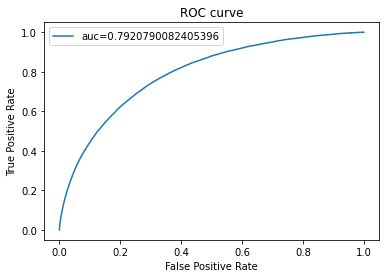

In [82]:
print("Train Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_train, cv_preds_proba)}")
fpr, tpr, thresh= roc_curve(y_train, cv_preds_proba)
auc = roc_auc_score(y_train, cv_preds_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)

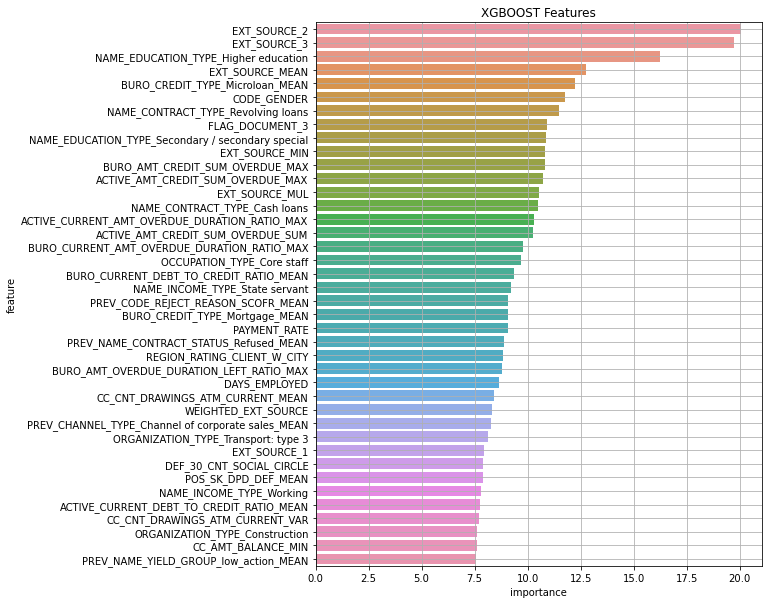

In [83]:
plt.figure(figsize=(8, 10))
num_features=40
sns.barplot(feature_importance['gain'].iloc[:num_features], feature_importance['features'].iloc[:num_features], orient = 'h')
plt.title('XGBOOST Features')
plt.xlabel('importance')
plt.ylabel('feature')
plt.grid()
plt.show()

In [84]:
#output
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : test_preds_proba_mean}).to_csv('xgboost2_v3.csv',index = False)

In [85]:
pd.DataFrame(cv_preds_proba).to_csv('xgb_cv_Preds_v3.csv',index = False)

## Method4: Stacking

In [86]:
def load_stacking_data( ):
#     global sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv
#     global sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test
    
    sgd_lr_l2_cv = pd.read_csv('LR_L2_CV_Preds.csv')
    xgb_cv = pd.read_csv('xgb_cv_Preds_v3.csv')
    lgbm_cv = pd.read_csv('lgbm_cv_Preds.csv')

    #loading the Predicted Probabilities of Test Set
    sgd_lr_l2_test = pd.read_csv('LR_L2.csv')['TARGET']
    xgb_test = pd.read_csv('xgboost2_v3.csv')['TARGET']
    lgbm_test = pd.read_csv('lgbm1.csv')['TARGET']

    #defining the training and test datasets
    stack_train = pd.DataFrame(np.squeeze(np.stack([sgd_lr_l2_cv, xgb_cv, lgbm_cv], axis = 1)), columns = ['SGD_LR_L2', 'XGB', 'LGBM'])
    stack_target = target_train.copy()
    stack_test = pd.concat([sgd_lr_l2_test, xgb_test, lgbm_test], axis = 1)
    stack_test.columns = ['SGD_LR_L2', 'XGB', 'LGBM']
        
    return stack_train, stack_test, stack_target

In [87]:
stack_train, stack_test, stack_target = load_stacking_data()

In [88]:
def lgbm_stacker_optimization(num_leaves, max_depth, min_split_gain, min_child_weight,
                             min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 8956
    }
    stratified_cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 96)
    
    cv_preds = np.zeros(stack_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(stack_train, stack_target):

        x_tr = stack_train.iloc[train_indices]
        y_tr = stack_target.iloc[train_indices]
        x_cv = stack_train.iloc[cv_indices]
        y_cv = stack_target.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(stack_target, cv_preds)

In [89]:
bopt_stacking = BayesianOptimization(lgbm_stacker_optimization, {'num_leaves' : (2,50),
                                                   'max_depth' : (2,6),
                                                   'min_split_gain' : (0, 0.5),
                                                   'min_child_weight' : (1,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.001,1),
                                                   'colsample_bytree' : (0.2,1),
                                                   'reg_alpha' : (0.00001, 0.3),
                                                   'reg_lambda' : (0.00001, 0.3)},
                                 random_state = 6569)

bayesian_optimization = bopt_stacking.maximize(n_iter = 10, init_points = 10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7804   |  0.7955   |  5.417    |  44.35    |  38.21    |  0.4826   |  19.51    |  0.06595  |  0.05161  |  0.5286   |
|  2        |  0.7937   |  0.7451   |  4.236    |  47.4     |  58.14    |  0.1048   |  47.96    |  0.2365   |  0.249    |  0.7261   |
|  3        |  0.7946   |  0.6329   |  4.483    |  32.69    |  24.78    |  0.3669   |  2.316    |  0.09315  |  0.09452  |  0.4668   |
|  4        |  0.7906   |  0.4877   |  4.83     |  70.16    |  64.09    |  0.2487   |  22.81    |  0.2672   |  0.01726  |  0.4483   |
|  5        |  0.7833   |  0.3603   |  5.12     |  68.84    |  64.73    |  0.1149   |  9.906    |  0.1364   |  0.05073  |  0.1665   |
|  6        |  0.7868   |  0.273    |  2.604    |  26.55    | 

In [90]:
#extracting the best parameters
target_values = []
for result in bopt_stacking.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 0.26612350275135993, 'max_depth': 4.309168224808582, 'min_child_samples': 12.312859303743243, 'min_child_weight': 1.0865601040380797, 'min_split_gain': 0.07607928885328125, 'num_leaves': 2.1142252882041515, 'reg_alpha': 0.12462710629947461, 'reg_lambda': 0.14279750775544767, 'subsample': 0.08558006060076673}


In [91]:
def Boosting(stack_train, stack_target, stack_test, num_folds,skid_test, stratified = False, output= False):
    #Process the name of factor and change it to Json standard format
    #data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = stack_train
    train_df['TARGET']=stack_target
    test_df = stack_test
    #test_df['SK_ID_CURR']=skid_test
    # Cross validation model
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            colsample_bytree= 0.777005917777368, 
            max_depth=3, 
            min_child_samples=43, 
            min_child_weight=9.223836586454116, 
            min_split_gain=0.07297767759639462,
            reg_alpha=0.015583802542867243,
            reg_lambda=0.21883161475419755,
            subsample=0.29967715403460243,
            nthread=4,
            n_estimators=10000,
            learning_rate=0.001,
            num_leaves=30,
            silent=-1,
            verbose=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if output:
        #test_df['TARGET'] = sub_preds
        pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : sub_preds}).to_csv('stacking.csv',index = False)
        #test_df[['SK_ID_CURR', 'TARGET']].to_csv('stacking.csv', index = False)
    return feature_importance_df,oof_preds

In [92]:

st_feature_importance_df,st_oof_preds = Boosting(stack_train, stack_target, stack_test,5,skid_test,output= True)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.794172	training's binary_logloss: 0.26332	valid_1's auc: 0.794684	valid_1's binary_logloss: 0.266932
[400]	training's auc: 0.794525	training's binary_logloss: 0.253856	valid_1's auc: 0.794869	valid_1's binary_logloss: 0.257312
[600]	training's auc: 0.795324	training's binary_logloss: 0.247744	valid_1's auc: 0.795742	valid_1's binary_logloss: 0.251087
Fold  1 AUC : 0.795777
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.79498	training's binary_logloss: 0.263619	valid_1's auc: 0.791951	valid_1's binary_logloss: 0.265298
[400]	training's auc: 0.795687	training's binary_logloss: 0.254081	valid_1's auc: 0.792517	valid_1's binary_logloss: 0.255908
[600]	training's auc: 0.795791	training's binary_logloss: 0.247927	valid_1's auc: 0.792677	valid_1's binary_logloss: 0.2498

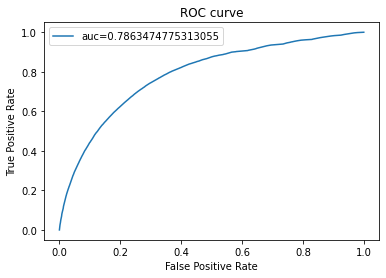

In [93]:
train_df = app_train[app_train['TARGET'].notnull()]
fpr, tpr, thresh= roc_curve(train_df['TARGET'], st_oof_preds)
auc = roc_auc_score(train_df['TARGET'], st_oof_preds)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)